# Import packages


In [1]:
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta
import math
import matplotlib.dates as mdates
import warnings

In [2]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
from tqdm import tqdm

# Load data


In [4]:
def load_data(stock_name, date_predict_start, data_range, slide_range, n_slide):
    train_data = {}
    test_data = {}
    date_predict_start = datetime.datetime.strptime(
        date_predict_start, '%Y-%m-%d').date()
    date_data_start_list = []
    date_predict_start_list = []
    date_predict_end_list = []
    test_data_start_list = []
    all_data = yf.Ticker(stock_name).history(period='max')
    all_data.index = all_data.index.date
    check = date_predict_start in all_data.index
    while (check == False):
        date_predict_start = date_predict_start + \
            relativedelta(days=+1)
        check = date_predict_start in list(all_data.index)
    predict_start = all_data.index.get_loc(date_predict_start)
    for i in range(n_slide):
        predict_end = predict_start + data_range
        date_predict_end = all_data.iloc[predict_end].name
        data_start = predict_start - data_range
        date_data_start = all_data.iloc[data_start].name
        train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
        test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
        date_data_start_list.append(date_data_start)
        date_predict_start_list.append(date_predict_start)
        date_predict_end_list.append(date_predict_end)
        test_data_start_list.append(test_data['data_' + str(i)].index[0])
        data_start = data_start + slide_range
        predict_start = predict_start + slide_range
        train_data['data_' + str(i)] = train_data['data_' +
                                                  str(i)].reset_index(drop=False)
        test_data['data_' + str(i)] = test_data['data_' +
                                                str(i)].reset_index(drop=False)

    return train_data, test_data, all_data, test_data_start_list


In [5]:
# stock_name = "^GSPC"
# date_predict_start = '2021-01-01'
# data_range = 10
# slide_range = 5
# n_slide = 3
# pv_range = 2
# n_harm_lower_limit = 3
# n_harm_upper_limit = 3
# fit_method = 'rmse'
# pv_method = 'HL'
# date_data_start_list = []
# date_predict_start_list = []
# date_predict_end_list = []
# train_data = {}
# test_data = {}
# date_predict_start = datetime.datetime.strptime(date_predict_start, '%Y-%m-%d')
# all_data = yf.Ticker(stock_name).history(period='max')

# check = date_predict_start in list(all_data.index)
# while (check == False) :
#     date_predict_start = date_predict_start + \
#         relativedelta(days=+1)
#     check = date_predict_start in list(all_data.index)
# predict_start = all_data.index.get_loc(date_predict_start)
# for i in range(n_slide):
#     predict_end = predict_start + data_range
#     date_predict_end = all_data.iloc[predict_end].name
#     data_start = predict_start - data_range
#     date_data_start = all_data.iloc[data_start].name
#     train_data['data_' + str(i)] = all_data.iloc[data_start:predict_start]
#     test_data['data_' + str(i)] = all_data.iloc[predict_start:predict_end]
#     date_data_start_list.append(date_data_start)
#     date_predict_start_list.append(date_predict_start)
#     date_predict_end_list.append(date_predict_end)
#     data_start = data_start + slide_range
#     predict_start = predict_start + slide_range


# Data preprocessing


In [6]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        price = data[i]['Close']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range and idx>0:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = price[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = price[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [7]:
def find_data_pv_HL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    for i in data:
        high = data[i]['High']
        low = data[i]['Low']
        data[i]['peaks'] = pd.Series(dtype='float64')
        data[i]['valleys'] = pd.Series(dtype='float64')
        data[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(high)):
            if idx < pv_range and idx>0:
                if high[idx] == high.iloc[0:pv_range*2+1].max():
                    data[i]['peaks'].iloc[idx] = high[idx]
                    data[i]['pv'].iloc[idx] = 'peak'
                if low[idx] == low.iloc[0:pv_range*2+1].min():
                    data[i]['valleys'].iloc[idx] = low[idx]
                    data[i]['pv'].iloc[idx] = 'valley'
            if high[idx] == high.iloc[idx-pv_range:idx+pv_range].max():
                data[i]['peaks'].iloc[idx] = high[idx]
                data[i]['pv'].iloc[idx] = 'peak'
            if low[idx] == low.iloc[idx-pv_range:idx+pv_range].min():
                data[i]['valleys'].iloc[idx] = low[idx]
                data[i]['pv'].iloc[idx] = 'valley'


In [8]:
def preprocessing(train_data, test_data, pv_range, pv_method):
    if pv_method == 'CL':
        find_data_pv_CL_function(train_data, pv_range)
        find_data_pv_CL_function(test_data, pv_range)
    elif pv_method == 'HL':
        find_data_pv_HL_function(train_data, pv_range)
        find_data_pv_HL_function(test_data, pv_range)
    else :
        print('worng pv_method')


# Built Model


Get signal


In [9]:
def data_to_harmonics_function(data_stock, data_range):
    harmonics = {}
    for i in data_stock:
        harmonics[i] = {}
        # get data_stock's infomation
        data = data_stock[i]['Close']
        array_data = np.array(data)
        n_data = array_data.size
        time_data = np.arange(0, n_data)

        # detrend data
        # find linear trend in data
        Polynomial = np.polyfit(time_data, array_data, 1)
        data_notrend = array_data - Polynomial[0] * time_data    # detrended x

        # fft process
        data_freqdom = fft.fft(data_notrend, n=n_data)
        frequence = fft.fftfreq(n=n_data, d=1)
        f_positive = frequence[np.where(frequence > 0)]
        data_freqdom_positive = data_freqdom[np.where(frequence > 0)]

        # sort indexes
        indexes = list(range(f_positive.size))      # frequencies
        # sort method 1
        # indexes.sort(key = lambda i: np.absolute(frequence[i]))     # sort indexes by frequency, lower -> higher
        # sort method 2 :
        # sort indexes by amplitudes, lower -> higher
        indexes.sort(key=lambda i: np.absolute(data_freqdom[i]))
        indexes.reverse()       # sort indexes by amplitudes, higher -> lower

        # get data_all_time'size
        time_transfer = np.arange(0, data_range*2)

        # mix harmonics
        for j in indexes:
            ampli = np.absolute(
                data_freqdom_positive[j]) / n_data     # amplitude
            phase = np.angle(data_freqdom_positive[j])      # phase
            harmonics[i][j] = ampli * \
                np.cos(2 * np.pi * f_positive[j] * time_transfer + phase)
    return harmonics


In [10]:
def mix_harmonics_function(harmonics, n_harm_lower_limit, n_harm_upper_limit):
    processed_signal = {}
    for i in harmonics:
        processed_signal[i] = {}
        for n_harm in range(n_harm_lower_limit, n_harm_upper_limit+1):
            mixed_harmonic = np.zeros(len(harmonics[i][0]))
            for j in range(n_harm):
                mixed_harmonic += harmonics[i][j]
            processed_signal[i][n_harm] = pd.DataFrame(
                {'Close': mixed_harmonic})
    return processed_signal


Signal processing


In [11]:
def find_signal_pv_function(signal, pv_range):
    pd.options.mode.chained_assignment = None
    for i in signal:
        for j in signal[i]:
            data = signal[i][j]['Close']
            signal[i][j]['peaks'] = pd.Series(dtype='float64')
            signal[i][j]['valleys'] = pd.Series(dtype='float64')
            signal[i][j]['pv'] = pd.Series(dtype='str')
            for idx in range(0, len(data)):
                if idx < pv_range and idx>0:
                    if data[idx] == data.iloc[0:pv_range*2+1].max():
                        signal[i][j]['peaks'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'peak'
                    if data[idx] == data.iloc[0:pv_range*2+1].min():
                        signal[i][j]['valleys'].iloc[idx] = data[idx]
                        signal[i][j]['pv'].iloc[idx] = 'valley'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                    signal[i][j]['peaks'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                    signal[i][j]['valleys'].iloc[idx] = data[idx]
                    signal[i][j]['pv'].iloc[idx] = 'valley'


In [12]:
def find_signal_lead_train_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            # processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].head(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [13]:
def build_model(train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range):
    harmonics = data_to_harmonics_function(train_data, data_range)
    processed_signal = mix_harmonics_function(
        harmonics, n_harm_lower_limit, n_harm_upper_limit)
    find_signal_pv_function(processed_signal, pv_range)
    find_signal_lead_train_function(train_data, processed_signal)
    return harmonics, processed_signal


# Select model


In [14]:
def get_fit_error_function(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        for j in processed_signal[i]:
            signal_dropna = processed_signal[i][j].drop(
                processed_signal[i][j][processed_signal[i][j]['lead'].isna()].index)
            if fit_method == 'mean':
                error = signal_dropna['lead'].mean()
            elif fit_method == 'abs':
                error = abs(signal_dropna['lead']).mean()
            elif fit_method == 'rmse':
                mse = np.square(np.subtract(np.zeros_like(
                    signal_dropna['lead']), signal_dropna['lead'])).mean()
                rmse = math.sqrt(mse)
                error = rmse
            else :
                print('worng fit_method')
            errors[i][j] = error
    return errors


In [15]:
def get_best_fit_harm_function(processed_signal, errors):
    best_error = {}
    best_fit_harm = {}
    for i in processed_signal:
        best_error[i] = pd.Series(errors[i]).abs().min()
        best_fit_harm[i] = pd.Series(errors[i]).abs().idxmin()
    return best_fit_harm, best_error


In [16]:
def find_signal_lead_test_function(data, processed_signal):
    for d in data:
        for p in processed_signal[d]:
            processed_signal[d][p]['pv'] = pd.Series(dtype='str')
            processing_signal = processed_signal[d][p].tail(len(data[d]))
            p_data = pd.DataFrame(
                {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
            p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
            p_data_count = list(p_data['count'])
            p_signal = pd.DataFrame(
                {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
            p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
            p_signal_list = list(p_signal['count'])
            p_lead = []
            for i in range(0, len(p_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(p_data_count)):
                    temp.append((p_data_count[j] - p_signal_list[i]))
                    temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                p_lead.append(temp_2)
            p_signal['lead'] = p_lead

            v_data = pd.DataFrame(
                {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
            v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
            v_data_count = list(v_data['count'])
            v_signal = pd.DataFrame(
                {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
            v_signal = v_signal.drop(
                v_signal[v_signal['valleys'].isna()].index)
            v_signal_list = list(v_signal['count'])
            v_lead = []
            for i in range(0, len(v_signal_list)):
                temp = []
                temp_abs = []
                temp_2 = []
                for j in range(0, len(v_data_count)):
                    temp.append((v_data_count[j] - v_signal_list[i]))
                    temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
                for k in range(0, len(temp_abs)):
                    if temp_abs[k] == min(temp_abs):
                        temp_2 = temp[k]
                v_lead.append(temp_2)
            v_signal['lead'] = v_lead

            processed_signal[d][p]['lead'] = pd.Series(dtype='float64')
            processed_signal[d][p]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
            processed_signal[d][p]['pv'].loc[p_signal['lead'].index] = 'peak'
            processed_signal[d][p]['lead'].loc[v_signal['lead'].index] = v_signal['lead']
            processed_signal[d][p]['pv'].loc[v_signal['lead'].index] = 'valley'


In [17]:
def get_first_lead_function(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        harm = best_fit_harm[i]
        temp = processed_signal[i][harm].loc[list(
            processed_signal[i][harm]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i][harm]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [18]:
def select_model(test_data, processed_signal, fit_method):
    errors = get_fit_error_function(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_signal_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


# Evaluate model


In [19]:
def built_result_table_function(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [20]:
def result_table_process_function(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(result_table.loc[i, 's_date']) + first_date[i] - data_range].name
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [21]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [22]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error


# Draw plot


In [23]:
def find_data_pv_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range and idx>0:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valley'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valley'


In [24]:
def draw_plot_result_table(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    for d in test_data :
        test_data[d].index = test_data[d]['index']
        test_data_cut = test_data[d].drop(test_data[d][test_data[d].index > date_list[-1]].index)
        axes[0].plot(test_data_cut.index, test_data_cut['Close'], 'gray', label='data', linewidth=3)
    for d in test_data :
        axes[0].plot(test_data[d].index, test_data[d]['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data[d].index, test_data[d]['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.show()

# Main function


In [25]:
def main_funtion(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, n_harm_lower_limit, n_harm_upper_limit, fit_method, pv_method):

    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    harmonics, model = build_model(
        train_data, n_harm_lower_limit, n_harm_upper_limit, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model(test_data,
                                                                           model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
        print(result_table)
    draw_plot_result_table(test_data, all_data, result_table, pv_range)
    return harmonics, model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [26]:
# stock_name = "^GSPC"
# date_predict_start = '2020-01-01'
# data_range = 250
# slide_range = 10
# n_slide = 2
# pv_range = 2
# order_lower_limit = 0
# order_upper_limit = 50
# fit_method = 'rmse'
# pv_method = 'HL'
# # 1. load_data
# train_data, test_data, all_data, test_data_start_list = load_data(
#     stock_name, date_predict_start, data_range, slide_range, n_slide)
# # 2. Preprocessing
# preprocessing(train_data, test_data, pv_range, pv_method)


In [27]:
def SARIMAX_predict_function(train_data, p_range, d_range, q_range, P_range, D_range, Q_range, s): 
    model_pdq = {}
    model_fit = {}
    model_prediction = {}
    for i in tqdm(train_data):
        train = train_data[i]['Close']
        index_length = len(p_range)*len(d_range)*len(q_range)*len(P_range)*len(D_range)*len(Q_range)
        model_pdq[i] = pd.DataFrame(columns=['p','d','q','P','D','Q','s'], index=range(0, index_length))
        model_fit[i] = {}
        model_prediction[i] = {}
        index = 0
        for p in tqdm(p_range):
            for d in d_range:
                for q in q_range:
                    for P in P_range:
                        for D in  D_range:
                            for Q in Q_range:
                                try:
                                    # Fit the SARIMA model to the training data
                                    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
                                    model_fit[i][index] = model.fit()
                                    model_prediction[i][index] = pd.DataFrame(columns=['Close'])
                                    model_prediction[i][index]['Close'] = model_fit[i][index].predict(start=train.index[0], end=train.index[-1]*2+1)
                                    model_pdq[i]['p'].iloc[index]=p
                                    model_pdq[i]['d'].iloc[index]=d
                                    model_pdq[i]['q'].iloc[index]=q
                                    model_pdq[i]['P'].iloc[index]=P
                                    model_pdq[i]['D'].iloc[index]=D
                                    model_pdq[i]['Q'].iloc[index]=Q
                                    model_pdq[i]['s'].iloc[index]=s
                                    index+=1
                                    print(i, index, '/', index_length)
                                except:
                                    pass

    return model_fit, model_prediction, model_pdq

In [28]:
def SARIMAX_select_model(model_fit, model_aic, data_range):
    best_predictions = {}
    min_value = int()
    for i in model_aic:
        min_key, min_value = min(
            zip(model_aic[i].keys(), model_aic[i].values()))
        best_predictions[i] = model_fit[i][0].predict(
            start=data_range, end=data_range*2-1)
    return best_predictions, min_value


In [29]:
# best_predictions, min_value = SARIMAX_select_model(model_fit, model_aic, data_range)

In [30]:
def draw_sarima_result(train_data, test_data, predictions):
    plt.figure(figsize=(20,6))
    plt.plot(train_data, label='train')
    plt.plot(predictions.index, test_data[:len(predictions)], label='test')
    plt.plot(predictions.index, predictions, label='predictions')
    # plt.xlim(len(train_data-10), len(train_data+10))
    plt.legend()
    plt.show()

In [31]:
def find_sarima_pv_function(sarima_predictions, pv_range):
    pd.options.mode.chained_assignment = None
    processed_signal = {}
    for i in sarima_predictions:
        processed_signal[i] = pd.DataFrame()
        price = sarima_predictions[i].reset_index(drop=True)
        processed_signal[i]['Close'] = sarima_predictions[i].reset_index(drop=True)
        processed_signal[i]['peaks'] = pd.Series(dtype='float64')
        processed_signal[i]['valleys'] = pd.Series(dtype='float64')
        processed_signal[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(price)):
            if idx < pv_range and idx>0:
                if price[idx] == price.iloc[0:pv_range*2+1].max():
                    processed_signal[i]['peaks'].iloc[idx] = price[idx]
                    processed_signal[i]['pv'].iloc[idx] = 'peak'
                if price[idx] == price.iloc[0:pv_range*2+1].min():
                    processed_signal[i]['valleys'].iloc[idx] = price[idx]
                    processed_signal[i]['pv'].iloc[idx] = 'valley'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
                processed_signal[i]['peaks'].iloc[idx] = price[idx]
                processed_signal[i]['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
                processed_signal[i]['valleys'].iloc[idx] = price[idx]
                processed_signal[i]['pv'].iloc[idx] = 'valley'
            # new rule for all zero
    return processed_signal


In [32]:
# processed_signal = find_sarima_pv_function(best_predictions, pv_range)

In [33]:
def find_sarima_lead_train_function(data, processed_signal):
    for d in data:
        # processed_signal[d]['pv'] = pd.Series(dtype='str')
        processing_signal = processed_signal[d].head(len(data[d]))
        # print(processing_signal)
        p_data = pd.DataFrame(
            {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
        p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
        p_data_count = list(p_data['count'])
        p_signal = pd.DataFrame(
            {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
        p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
        p_signal_list = list(p_signal['count'])
        p_lead = []
        for i in range(0, len(p_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_count)):
                temp.append((p_data_count[j] - p_signal_list[i]))
                temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            p_lead.append(temp_2)
        p_signal['lead'] = p_lead

        v_data = pd.DataFrame(
            {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
        v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
        v_data_count = list(v_data['count'])
        v_signal = pd.DataFrame(
            {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
        v_signal = v_signal.drop(
            v_signal[v_signal['valleys'].isna()].index)
        v_signal_list = list(v_signal['count'])
        v_lead = []
        for i in range(0, len(v_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_count)):
                temp.append((v_data_count[j] - v_signal_list[i]))
                temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            v_lead.append(temp_2)
        v_signal['lead'] = v_lead

        processed_signal[d]['lead'] = pd.Series(dtype='float64')
        processed_signal[d]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
        processed_signal[d]['lead'].loc[v_signal['lead'].index] = v_signal['lead']

In [34]:
# find_sarima_lead_train_function(train_data, processed_signal)

In [35]:
def build_model_sarima(train_data, pv_range, data_range):
    p_range = range(0, 3)
    d_range = range(0, 3)
    q_range = range(1, 2)
    P_range = range(0, 3)
    D_range = range(0, 3)
    Q_range = range(1, 2)
    s = 12
    model_fit, model_aic, model_pdq = SARIMAX_predict_function(train_data, p_range, d_range, q_range, P_range, D_range, Q_range, s) # type: ignore
    best_predictions, min_value = SARIMAX_select_model(model_fit, model_aic, data_range)
    processed_signal = find_sarima_pv_function(best_predictions, pv_range)
    find_sarima_lead_train_function(train_data, processed_signal)
    return processed_signal

In [36]:
# processed_signal = build_model_sarima(train_data, pv_range, data_range)

In [37]:
def get_fit_error_function_sarima(processed_signal, fit_method):
    errors = {}
    error = []
    for i in processed_signal:
        errors[i] = {}
        signal_dropna = processed_signal[i].drop(
            processed_signal[i][processed_signal[i]['lead'].isna()].index)
        if fit_method == 'mean':
            error = signal_dropna['lead'].mean()
        elif fit_method == 'abs':
            error = abs(signal_dropna['lead']).mean()
        elif fit_method == 'rmse':
            mse = np.square(np.subtract(np.zeros_like(
                signal_dropna['lead']), signal_dropna['lead'])).mean()
            rmse = math.sqrt(mse)
            error = rmse
        else :
            print('worng fit_method')
        errors[i] = error
    return errors


In [38]:
def find_sarima_lead_test_function(data, processed_signal):
    for d in data:
        # processed_signal[d]['pv'] = pd.Series(dtype='str')
        processing_signal = processed_signal[d].tail(len(data[d]))
        p_data = pd.DataFrame(
            {'peaks': data[d]['peaks'], 'count': range(len(data[d]))})
        p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
        p_data_count = list(p_data['count'])
        p_signal = pd.DataFrame(
            {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
        p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
        p_signal_list = list(p_signal['count'])
        p_lead = []
        for i in range(0, len(p_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_count)):
                temp.append((p_data_count[j] - p_signal_list[i]))
                temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            p_lead.append(temp_2)
        p_signal['lead'] = p_lead

        v_data = pd.DataFrame(
            {'valleys': data[d]['valleys'], 'count': range(len(data[d]))})
        v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
        v_data_count = list(v_data['count'])
        v_signal = pd.DataFrame(
            {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
        v_signal = v_signal.drop(
            v_signal[v_signal['valleys'].isna()].index)
        v_signal_list = list(v_signal['count'])
        v_lead = []
        for i in range(0, len(v_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_count)):
                temp.append((v_data_count[j] - v_signal_list[i]))
                temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            v_lead.append(temp_2)
        v_signal['lead'] = v_lead

        processed_signal[d]['lead'] = pd.Series(dtype='float64')
        processed_signal[d]['lead'].loc[p_signal['lead'].index] = p_signal['lead']
        processed_signal[d]['lead'].loc[v_signal['lead'].index] = v_signal['lead']


In [39]:
def get_first_lead_function_sarima(processed_signal, best_fit_harm):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        temp = processed_signal[i].loc[list(
            processed_signal[i]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [40]:
def select_model_sarima(test_data, processed_signal, fit_method):
    errors = get_fit_error_function_sarima(processed_signal, fit_method)
    best_fit_harm, best_error = get_best_fit_harm_function(
        processed_signal, errors)
    find_sarima_lead_test_function(test_data, processed_signal)
    first_date, lead, pv = get_first_lead_function_sarima(
        processed_signal, best_fit_harm)
    return errors, best_fit_harm, best_error, first_date, lead, pv


In [41]:
# errors, best_fit_harm, best_error, first_date, lead, pv = select_model_sarima(test_data, processed_signal, fit_method)

In [42]:
def result_table_process_function_sarima(result_table, all_data, first_date, data_range):
    for i in result_table.index:
        t_date = all_data.iloc[all_data.index.get_loc(
            datetime.datetime.strptime(result_table.loc[i].s_date, '%Y-%m-%d').date()) + first_date[i] - data_range].name
        t_date = datetime.datetime.strftime(t_date, '%Y-%m-%d')
        result_table.loc[i, 't_date'] = t_date
        ans = all_data.iloc[int(all_data.index.get_loc(
            datetime.datetime.strptime(result_table.loc[i].s_date, '%Y-%m-%d').date()) + result_table.loc[i, 'lead'])].name
        ans = datetime.datetime.strftime(ans, '%Y-%m-%d')
        result_table.loc[i, 'ans_date'] = ans


In [43]:
def evaluate_model_sarima(best_predictions, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        best_predictions, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function_sarima(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error

In [44]:
def built_result_table_function_sarima(processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv', 'error', 'best_fit'])
    for i in processed_signal:
        result_table.loc[i, 'error'] = round(best_error[i], 2)
        result_table.loc[i, 'best_fit'] = best_fit_harm[i]
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
    result_table['s_date'] = test_data_start_list
    return result_table


In [45]:
# result_table = built_result_table_function_sarima(
#         processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)

In [46]:
# result_table_process_function_sarima(
#         result_table, all_data, first_date, data_range)

In [47]:
# final_error = compute_final_error_function(result_table)

In [48]:
# result_table, final_error = evaluate_model_sarima(
#     processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
# print('final_error = ', final_error)
# with pd.option_context('display.max_rows', None,
#                     'display.max_columns', None,
#                     'display.precision', 3,
#                     ):
#     print(result_table)

In [49]:
# def draw_sarima_result(test_data, model_prediction, best_fit_harm):
#     for i in test_data:
#         fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
#         print(i)
#         pdq = best_fit_harm[i]
#         prediction = model_prediction[i][pdq].loc[len(test_data[i]['Close']): len(test_data[i]['Close'])*2]
#         prediction.index = test_data[i]['Close'].index
#         axes[0].plot(test_data[i]['Close'].index, test_data[i]['Close'], label='test')
#         axes[1].plot(prediction['Close'].index, prediction['Close'], label='predictions')
#         for j, label in enumerate(prediction['pv']):
#             if test_data[i]['pv'][j] == 'peak':
#                 axes[0].plot(test_data[i]['Close'].index[j], test_data[i]['Close'][j], '^',
#                             c='royalblue')
#             elif test_data[i]['pv'][j] == 'valley':
#                 axes[0].plot(test_data[i]['Close'].index[j], test_data[i]['Close'][j], 'v',
#                             c='orangered')
#             if prediction['pv'][j] == 'peak':
#                 axes[1].plot(prediction['Close'].index[j], prediction['Close'][j], '^',
#                             c='royalblue')
#             elif prediction['pv'][j] == 'valley':
#                 axes[1].plot(prediction['Close'].index[j], prediction['Close'][j], 'v',
#                             c='orangered')
#         plt.legend()
#         plt.show()

In [50]:
# def draw_plot_result_table_sarima(test_data, all_data, result_table, pv_range):
#     date_list = sorted(
#         list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
#     all_index = all_data.loc[datetime.datetime.strptime(date_list[0], '%Y-%m-%d').date():datetime.datetime.strptime(date_list[-1], '%Y-%m-%d').date()].index
#     fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
#     for d in test_data :
#         test_data[d].index = test_data[d]['index']
#         test_data[d]= test_data[d].drop(test_data[d][test_data[d].index > datetime.datetime.strptime(date_list[-1], '%Y-%m-%d').date()].index)
#         axes[0].plot(test_data[d].index, test_data[d]['Close'], 'gray', label='data', linewidth=3)
#     for d in test_data :
#         axes[0].plot(test_data[d].index, test_data[d]['peaks'],
#                     '^', c='royalblue', label='peaks')
#         axes[0].plot(test_data[d].index, test_data[d]['valleys'], 'v',
#                     c='orangered', label='valleys')
#     plot_model = pd.DataFrame(index=all_index, columns=[
#                                 's_date', 't_date', 'ans_date', 'lead', 'pv'])
#     print(plot_model)
#     # plot_model['s_date'].loc[result_table['s_date']] = True
#     # plot_model['t_date'].loc[result_table['t_date']] = True
#     # plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
#     # plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
#     # plot_model['ans_date'].loc[result_table['ans_date']] = True
#     # for i, label in enumerate(plot_model['lead']):
#     #     if plot_model['pv'][i] == 'peak':
#     #         # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#     #         #             c='red')
#     #         axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
#     #                         c='royalblue')
#     #         text = str(label)
#     #         axes[1].annotate(text, (plot_model.index[i],
#     #                             plot_model['lead'][i]), fontsize=14)
#     #     elif plot_model['pv'][i] == 'valley':
#     #         # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#     #         #             c='red')
#     #         axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
#     #                         c='orangered')
#     #         text = str(label)
#     #         axes[1].annotate(text, (plot_model.index[i],
#     #                             plot_model['lead'][i]), fontsize=14)

#     # axes[0].set_ylabel("Stock price", fontsize=14)
#     # axes[0].grid(True)
#     # axes[1].grid(True)
#     # axes[1].set_ylabel("lead", fontsize=14)
#     # plt.show()

In [51]:
def main_funtion_sarima(
    stock_name, date_predict_start, data_range, slide_range,
        n_slide, pv_range, fit_method, pv_method):
    # 1. Load data
    train_data, test_data, all_data, test_data_start_list = load_data(
        stock_name, date_predict_start, data_range, slide_range, n_slide)
    # 2. Preprocessing
    preprocessing(train_data, test_data, pv_range, pv_method)
    # 3. Build model
    model = build_model_sarima(train_data, pv_range, data_range)
    # 4. Select model
    errors, best_fit_harm, best_error, first_date, lead, pv = select_model_sarima(test_data, model, fit_method)
    # 5. Evaluate model
    result_table, final_error = evaluate_model_sarima(
        model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
    print('final_error = ', final_error)
    with pd.option_context('display.max_rows', None,
                        'display.max_columns', None,
                        'display.precision', 3,
                        ):
        print(result_table)
    return model, errors, best_fit_harm, best_error, first_date, lead, pv, result_table, final_error


In [52]:
stock_name = "^GSPC"
date_predict_start = '2020-01-01'
data_range = 250
slide_range = 10
n_slide = 10
pv_range = 5
fit_method = 'rmse'
pv_method = 'CL'

In [53]:
# 1. Load data
train_data, test_data, all_data, test_data_start_list = load_data(
    stock_name, date_predict_start, data_range, slide_range, n_slide)

In [54]:
# 2. Preprocessing
preprocessing(train_data, test_data, pv_range, pv_method)

In [55]:
# 3. Build model
p_range = range(0, 3)
d_range = range(0, 3)
q_range = range(1, 2)
P_range = range(0, 3)
D_range = range(0, 3)
Q_range = range(1, 2)
s = 12
model_fit, model_prediction, model_pdq = SARIMAX_predict_function(
    train_data, p_range, d_range, q_range, P_range, D_range, Q_range, s) # type: ignore


  0%|          | 0/10 [00:00<?, ?it/s]

data_0 1 / 81
data_0 2 / 81
data_0 3 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_0 4 / 81
data_0 5 / 81
data_0 6 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 7 / 81
data_0 8 / 81
data_0 9 / 81
data_0 10 / 81
data_0 11 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 12 / 81
data_0 13 / 81
data_0 14 / 81
data_0 15 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 16 / 81
data_0 17 / 81
data_0 18 / 81
data_0 19 / 81
data_0 20 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 21 / 81
data_0 22 / 81
data_0 23 / 81
data_0 24 / 81
data_0 25 / 81
data_0 26 / 81


data_0 27 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


data_0 28 / 81
data_0 29 / 81
data_0 30 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_0 31 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 32 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 33 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_0 34 / 81
data_0 35 / 81
data_0 36 / 81
data_0 37 / 81
data_0 38 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 39 / 81
data_0 40 / 81
data_0 41 / 81
data_0 42 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 43 / 81
data_0 44 / 81
data_0 45 / 81
data_0 46 / 81
data_0 47 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 48 / 81
data_0 49 / 81
data_0 50 / 81
data_0 51 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 52 / 81
data_0 53 / 81


data_0 54 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_0 55 / 81
data_0 56 / 81
data_0 57 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_0 58 / 81
data_0 59 / 81
data_0 60 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_0 61 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 62 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 63 / 81
data_0 64 / 81
data_0 65 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 66 / 81
data_0 67 / 81
data_0 68 / 81
data_0 69 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 70 / 81
data_0 71 / 81
data_0 72 / 81
data_0 73 / 81
data_0 74 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_0 75 / 81
data_0 76 / 81
data_0 77 / 81
data_0 78 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_0 79 / 81
data_0 80 / 81


 10%|█         | 1/10 [03:24<30:39, 204.36s/it]

data_0 81 / 81


data_1 1 / 81
data_1 2 / 81
data_1 3 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_1 4 / 81
data_1 5 / 81
data_1 6 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_1 7 / 81
data_1 8 / 81
data_1 9 / 81
data_1 10 / 81
data_1 11 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_1 12 / 81
data_1 13 / 81
data_1 14 / 81
data_1 15 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 16 / 81
data_1 17 / 81
data_1 18 / 81
data_1 19 / 81
data_1 20 / 81
data_1 21 / 81
data_1 22 / 81
data_1 23 / 81
data_1 24 / 81
data_1 25 / 81
data_1 26 / 81


data_1 27 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


data_1 28 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 29 / 81
data_1 30 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_1 31 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 32 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 33 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_1 34 / 81
data_1 35 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 36 / 81
data_1 37 / 81
data_1 38 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_1 39 / 81
data_1 40 / 81
data_1 41 / 81
data_1 42 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 43 / 81
data_1 44 / 81
data_1 45 / 81
data_1 46 / 81
data_1 47 / 81
data_1 48 / 81
data_1 49 / 81
data_1 50 / 81
data_1 51 / 81
data_1 52 / 81
data_1 53 / 81


data_1 54 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_1 55 / 81
data_1 56 / 81
data_1 57 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 58 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 59 / 81
data_1 60 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 61 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 62 / 81
data_1 63 / 81
data_1 64 / 81
data_1 65 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 66 / 81
data_1 67 / 81
data_1 68 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 69 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 70 / 81
data_1 71 / 81
data_1 72 / 81
data_1 73 / 81
data_1 74 / 81
data_1 75 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_1 76 / 81
data_1 77 / 81
data_1 78 / 81
data_1 79 / 81
data_1 80 / 81


 20%|██        | 2/10 [06:33<26:02, 195.25s/it]

data_1 81 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 1 / 81
data_2 2 / 81
data_2 3 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_2 4 / 81
data_2 5 / 81
data_2 6 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 7 / 81
data_2 8 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 9 / 81
data_2 10 / 81
data_2 11 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 12 / 81
data_2 13 / 81
data_2 14 / 81
data_2 15 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 16 / 81
data_2 17 / 81
data_2 18 / 81
data_2 19 / 81
data_2 20 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 21 / 81
data_2 22 / 81
data_2 23 / 81
data_2 24 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 25 / 81
data_2 26 / 81


data_2 27 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 28 / 81
data_2 29 / 81
data_2 30 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_2 31 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 32 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 33 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_2 34 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 35 / 81
data_2 36 / 81
data_2 37 / 81
data_2 38 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 39 / 81
data_2 40 / 81
data_2 41 / 81
data_2 42 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 43 / 81
data_2 44 / 81
data_2 45 / 81
data_2 46 / 81
data_2 47 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 48 / 81
data_2 49 / 81
data_2 50 / 81
data_2 51 / 81
data_2 52 / 81
data_2 53 / 81


data_2 54 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 55 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 56 / 81
data_2 57 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_2 58 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 59 / 81
data_2 60 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_2 61 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 62 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 63 / 81
data_2 64 / 81
data_2 65 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 66 / 81
data_2 67 / 81
data_2 68 / 81
data_2 69 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 70 / 81
data_2 71 / 81
data_2 72 / 81
data_2 73 / 81
data_2 74 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_2 75 / 81
data_2 76 / 81
data_2 77 / 81
data_2 78 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_2 79 / 81
data_2 80 / 81


 30%|███       | 3/10 [09:52<23:01, 197.31s/it]

data_2 81 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 1 / 81
data_3 2 / 81
data_3 3 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_3 4 / 81
data_3 5 / 81
data_3 6 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_3 7 / 81
data_3 8 / 81
data_3 9 / 81
data_3 10 / 81
data_3 11 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 12 / 81
data_3 13 / 81
data_3 14 / 81
data_3 15 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 16 / 81
data_3 17 / 81
data_3 18 / 81
data_3 19 / 81
data_3 20 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 21 / 81
data_3 22 / 81
data_3 23 / 81
data_3 24 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 25 / 81
data_3 26 / 81


data_3 27 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 28 / 81
data_3 29 / 81
data_3 30 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_3 31 / 81
data_3 32 / 81
data_3 33 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_3 34 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 35 / 81
data_3 36 / 81
data_3 37 / 81
data_3 38 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 39 / 81
data_3 40 / 81
data_3 41 / 81
data_3 42 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 43 / 81
data_3 44 / 81
data_3 45 / 81
data_3 46 / 81
data_3 47 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 48 / 81
data_3 49 / 81
data_3 50 / 81
data_3 51 / 81
data_3 52 / 81
data_3 53 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 54 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 55 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_3 56 / 81
data_3 57 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903

data_3 58 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 59 / 81
data_3 60 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_3 61 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 62 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 63 / 81
data_3 64 / 81
data_3 65 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 66 / 81
data_3 67 / 81
data_3 68 / 81
data_3 69 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 70 / 81
data_3 71 / 81
data_3 72 / 81
data_3 73 / 81
data_3 74 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_3 75 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 76 / 81
data_3 77 / 81
data_3 78 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_3 79 / 81
data_3 80 / 81


 40%|████      | 4/10 [13:16<19:58, 199.75s/it]

data_3 81 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 1 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 2 / 81
data_4 3 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_4 4 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 5 / 81
data_4 6 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_4 7 / 81
data_4 8 / 81
data_4 9 / 81
data_4 10 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 11 / 81
data_4 12 / 81
data_4 13 / 81
data_4 14 / 81
data_4 15 / 81
data_4 16 / 81
data_4 17 / 81
data_4 18 / 81
data_4 19 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 20 / 81
data_4 21 / 81
data_4 22 / 81
data_4 23 / 81
data_4 24 / 81
data_4 25 / 81


data_4 26 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 27 / 81
data_4 28 / 81
data_4 29 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_4 30 / 81
data_4 31 / 81
data_4 32 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_4 33 / 81
data_4 34 / 81
data_4 35 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 36 / 81
data_4 37 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 38 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 39 / 81
data_4 40 / 81
data_4 41 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 42 / 81
data_4 43 / 81
data_4 44 / 81
data_4 45 / 81
data_4 46 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 47 / 81
data_4 48 / 81
data_4 49 / 81
data_4 50 / 81
data_4 51 / 81
data_4 52 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 53 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 54 / 81
data_4 55 / 81
data_4 56 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_4 57 / 81
data_4 58 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 59 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 60 / 81
data_4 61 / 81
data_4 62 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 63 / 81
data_4 64 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 65 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 66 / 81
data_4 67 / 81
data_4 68 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_4 69 / 81
data_4 70 / 81
data_4 71 / 81
data_4 72 / 81
data_4 73 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_4 74 / 81
data_4 75 / 81
data_4 76 / 81
data_4 77 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_4 78 / 81
data_4 79 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 50%|█████     | 5/10 [16:52<17:08, 205.77s/it]

data_4 80 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_5 1 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 2 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 3 / 81
data_5 4 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 5 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 6 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 7 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_5 8 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 9 / 81
data_5 10 / 81
data_5 11 / 81
data_5 12 / 81
data_5 13 / 81
data_5 14 / 81
data_5 15 / 81
data_5 16 / 81
data_5 17 / 81
data_5 18 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 19 / 81
data_5 20 / 81
data_5 21 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 22 / 81
data_5 23 / 81
data_5 24 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 25 / 81
data_5 26 / 81


data_5 27 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_5 28 / 81
data_5 29 / 81
data_5 30 / 81
data_5 31 / 81
data_5 32 / 81
data_5 33 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_5 34 / 81
data_5 35 / 81
data_5 36 / 81
data_5 37 / 81
data_5 38 / 81
data_5 39 / 81
data_5 40 / 81
data_5 41 / 81
data_5 42 / 81
data_5 43 / 81
data_5 44 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_5 45 / 81
data_5 46 / 81
data_5 47 / 81
data_5 48 / 81
data_5 49 / 81
data_5 50 / 81
data_5 51 / 81
data_5 52 / 81
data_5 53 / 81


data_5 54 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_5 55 / 81
data_5 56 / 81
data_5 57 / 81
data_5 58 / 81
data_5 59 / 81
data_5 60 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_5 61 / 81
data_5 62 / 81
data_5 63 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 64 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 65 / 81
data_5 66 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 67 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 68 / 81
data_5 69 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 70 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_5 71 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_5 72 / 81
data_5 73 / 81
data_5 74 / 81
data_5 75 / 81
data_5 76 / 81
data_5 77 / 81
data_5 78 / 81
data_5 79 / 81
data_5 80 / 81


 60%|██████    | 6/10 [20:03<13:22, 200.64s/it]

data_5 81 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_6 1 / 81
data_6 2 / 81
data_6 3 / 81
data_6 4 / 81
data_6 5 / 81
data_6 6 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_6 7 / 81
data_6 8 / 81
data_6 9 / 81
data_6 10 / 81
data_6 11 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_6 12 / 81
data_6 13 / 81
data_6 14 / 81
data_6 15 / 81
data_6 16 / 81
data_6 17 / 81
data_6 18 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 19 / 81
data_6 20 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_6 21 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 22 / 81
data_6 23 / 81
data_6 24 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 25 / 81
data_6 26 / 81


data_6 27 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_6 28 / 81
data_6 29 / 81
data_6 30 / 81
data_6 31 / 81
data_6 32 / 81
data_6 33 / 81
data_6 34 / 81
data_6 35 / 81
data_6 36 / 81
data_6 37 / 81
data_6 38 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_6 39 / 81
data_6 40 / 81
data_6 41 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_6 42 / 81
data_6 43 / 81
data_6 44 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 45 / 81
data_6 46 / 81
data_6 47 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_6 48 / 81
data_6 49 / 81
data_6 50 / 81
data_6 51 / 81
data_6 52 / 81
data_6 53 / 81


data_6 54 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_6 55 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 56 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 57 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 58 / 81
data_6 59 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 60 / 81
data_6 61 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 62 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 63 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 64 / 81
data_6 65 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_6 66 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 67 / 81
data_6 68 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 69 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 70 / 81
data_6 71 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_6 72 / 81
data_6 73 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 74 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_6 75 / 81
data_6 76 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 77 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_6 78 / 81
data_6 79 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_6 80 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 70%|███████   | 7/10 [23:16<09:54, 198.26s/it]

data_6 81 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_7 1 / 81
data_7 2 / 81
data_7 3 / 81
data_7 4 / 81
data_7 5 / 81
data_7 6 / 81
data_7 7 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 8 / 81
data_7 9 / 81
data_7 10 / 81
data_7 11 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_7 12 / 81
data_7 13 / 81
data_7 14 / 81
data_7 15 / 81
data_7 16 / 81
data_7 17 / 81
data_7 18 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_7 19 / 81
data_7 20 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_7 21 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_7 22 / 81
data_7 23 / 81
data_7 24 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_7 25 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 26 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 27 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_7 28 / 81
data_7 29 / 81
data_7 30 / 81
data_7 31 / 81
data_7 32 / 81
data_7 33 / 81
data_7 34 / 81
data_7 35 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 36 / 81
data_7 37 / 81
data_7 38 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_7 39 / 81
data_7 40 / 81
data_7 41 / 81
data_7 42 / 81
data_7 43 / 81
data_7 44 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 45 / 81
data_7 46 / 81
data_7 47 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_7 48 / 81
data_7 49 / 81
data_7 50 / 81
data_7 51 / 81
data_7 52 / 81
data_7 53 / 81


data_7 54 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_7 55 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\

data_7 56 / 81
data_7 57 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_7 58 / 81
data_7 59 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 60 / 81
data_7 61 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 62 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 63 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


data_7 64 / 81
data_7 65 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_7 66 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 67 / 81
data_7 68 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 69 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 70 / 81
data_7 71 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 72 / 81
data_7 73 / 81
data_7 74 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_7 75 / 81
data_7 76 / 81
data_7 77 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 78 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_7 79 / 81
data_7 80 / 81


 80%|████████  | 8/10 [27:10<06:59, 209.52s/it]

data_7 81 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 1 / 81
data_8 2 / 81
data_8 3 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_8 4 / 81
data_8 5 / 81
data_8 6 / 81
data_8 7 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_8 8 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_8 9 / 81
data_8 10 / 81
data_8 11 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 12 / 81
data_8 13 / 81
data_8 14 / 81
data_8 15 / 81
data_8 16 / 81
data_8 17 / 81
data_8 18 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_8 19 / 81
data_8 20 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 21 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_8 22 / 81
data_8 23 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 24 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_8 25 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_8 26 / 81


data_8 27 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 28 / 81
data_8 29 / 81
data_8 30 / 81
data_8 31 / 81
data_8 32 / 81
data_8 33 / 81
data_8 34 / 81
data_8 35 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


data_8 36 / 81
data_8 37 / 81
data_8 38 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 39 / 81
data_8 40 / 81
data_8 41 / 81
data_8 42 / 81
data_8 43 / 81
data_8 44 / 81
data_8 45 / 81
data_8 46 / 81
data_8 47 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 48 / 81
data_8 49 / 81
data_8 50 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 51 / 81
data_8 52 / 81
data_8 53 / 81


data_8 54 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 55 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_8 56 / 81
data_8 57 / 81
data_8 58 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_8 59 / 81
data_8 60 / 81
data_8 61 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_8 62 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_8 63 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_8 64 / 81
data_8 65 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 66 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_8 67 / 81
data_8 68 / 81
data_8 69 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_8 70 / 81
data_8 71 / 81
data_8 72 / 81
data_8 73 / 81
data_8 74 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_8 75 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_8 76 / 81
data_8 77 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_8 78 / 81
data_8 79 / 81
data_8 80 / 81


 90%|█████████ | 9/10 [30:47<03:31, 211.97s/it]

data_8 81 / 81


data_9 1 / 81
data_9 2 / 81
data_9 3 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_9 4 / 81
data_9 5 / 81
data_9 6 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_9 7 / 81
data_9 8 / 81
data_9 9 / 81
data_9 10 / 81
data_9 11 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_9 12 / 81
data_9 13 / 81
data_9 14 / 81
data_9 15 / 81
data_9 16 / 81
data_9 17 / 81
data_9 18 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_9 19 / 81
data_9 20 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_9 21 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_9 22 / 81
data_9 23 / 81
data_9 24 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_9 25 / 81
data_9 26 / 81


data_9 27 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


data_9 28 / 81
data_9 29 / 81
data_9 30 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


data_9 31 / 81
data_9 32 / 81
data_9 33 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


data_9 34 / 81
data_9 35 / 81
data_9 36 / 81
data_9 37 / 81
data_9 38 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_9 39 / 81
data_9 40 / 81
data_9 41 / 81
data_9 42 / 81
data_9 43 / 81
data_9 44 / 81
data_9 45 / 81
data_9 46 / 81
data_9 47 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_9 48 / 81
data_9 49 / 81
data_9 50 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_9 51 / 81
data_9 52 / 81
data_9 53 / 81


data_9 54 / 81
data_9 55 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


data_9 56 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_9 57 / 81
data_9 58 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


data_9 59 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_9 60 / 81
data_9 61 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_9 62 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_9 63 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_9 64 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_9 65 / 81
data_9 66 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_9 67 / 81
data_9 68 / 81
data_9 69 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


data_9 70 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_9 71 / 81
data_9 72 / 81
data_9 73 / 81
data_9 74 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


data_9 75 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_9 76 / 81
data_9 77 / 81
data_9 78 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


data_9 79 / 81
data_9 80 / 81


c:\Users\e4903\Desktop\code\myenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
100%|██████████| 10/10 [34:26<00:00, 206.69s/it]

data_9 81 / 81


In [56]:
find_signal_pv_function(model_prediction, pv_range)
find_signal_lead_train_function(train_data, model_prediction)

In [57]:
errors = get_fit_error_function(model_prediction, fit_method)
best_fit_harm, best_error = get_best_fit_harm_function(
    model_prediction, errors)
find_signal_lead_test_function(test_data, model_prediction)
first_date, lead, pv = get_first_lead_function(
    model_prediction, best_fit_harm)

In [58]:
for i in best_fit_harm:
    pdq = best_fit_harm[i]
    print(i)
    print(model_pdq[i].loc[pdq])

data_0
p     1
d     0
q     1
P     1
D     0
Q     1
s    12
Name: 30, dtype: object
data_1
p     1
d     0
q     1
P     1
D     0
Q     1
s    12
Name: 30, dtype: object
data_2
p     1
d     0
q     1
P     1
D     0
Q     1
s    12
Name: 30, dtype: object
data_3
p     1
d     0
q     1
P     1
D     0
Q     1
s    12
Name: 30, dtype: object
data_4
p     0
d     1
q     1
P     0
D     1
Q     1
s    12
Name: 9, dtype: object
data_5
p     1
d     0
q     1
P     1
D     0
Q     1
s    12
Name: 30, dtype: object
data_6
p     1
d     0
q     1
P     1
D     0
Q     1
s    12
Name: 30, dtype: object
data_7
p     1
d     0
q     1
P     1
D     0
Q     1
s    12
Name: 30, dtype: object
data_8
p     0
d     2
q     1
P     1
D     0
Q     1
s    12
Name: 21, dtype: object
data_9
p     0
d     2
q     1
P     1
D     0
Q     1
s    12
Name: 21, dtype: object


In [59]:
# 5. Evaluate model
# result_table, final_error = evaluate_model(
#     model, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range)
result_table = built_result_table_function(
    model_prediction, test_data_start_list, lead, pv, best_error, best_fit_harm)
result_table_process_function(
    result_table, all_data, first_date, data_range)
final_error = compute_final_error_function(result_table)
print('final_error = ', final_error)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    print(result_table)


final_error =  5.4
            s_date      t_date  lead    ans_date      pv error best_fit
data_0  2020-01-02  2020-01-10  -5.0  2020-01-03  valley  1.11       30
data_1  2020-01-16  2020-01-21  -1.0  2020-01-17    peak   1.0       30
data_2  2020-01-31  2020-02-06   8.0  2020-02-19    peak  1.06       30
data_3  2020-02-14  2020-02-25  -4.0  2020-02-19    peak  1.04       30
data_4  2020-03-02  2020-03-02  15.0  2020-03-23  valley  3.55        9
data_5  2020-03-16  2020-04-02  -1.0  2020-04-01  valley  1.22       30
data_6  2020-03-30  2020-04-14   3.0  2020-04-17    peak  1.27       30
data_7  2020-04-14  2020-04-22  -1.0  2020-04-21  valley  1.48       30
data_8  2020-04-28  2020-04-28   1.0  2020-04-29    peak  1.22       21
data_9  2020-05-12  2020-05-15  15.0  2020-06-08    peak  1.15       21


In [60]:
def draw_plot_result_table_1(test_data, all_data, result_table, pv_range):
    date_list = sorted(
        list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
    all_index = all_data.loc[date_list[0]:date_list[-1]].index
    fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
    test_data_copy = test_data.copy()
    for d in test_data :
        test_data[d].index = test_data[d]['index']
        test_data_copy = test_data[d].drop(test_data[d][test_data[d].index > date_list[-1]].index)
        axes[0].plot(test_data_copy.index, test_data_copy['Close'], 'gray', label='data', linewidth=3)
        axes[0].plot(test_data_copy.index, test_data_copy['peaks'],
                    '^', c='royalblue', label='peaks')
        axes[0].plot(test_data_copy.index, test_data_copy['valleys'], 'v',
                    c='orangered', label='valleys')
    plot_model = pd.DataFrame(index=all_index, columns=[
                                's_date', 't_date', 'ans_date', 'lead', 'pv'])
    plot_model['s_date'].loc[result_table['s_date']] = True
    plot_model['t_date'].loc[result_table['t_date']] = True
    plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
    plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
    plot_model['ans_date'].loc[result_table['ans_date']] = True
    for i, label in enumerate(plot_model['lead']):
        if plot_model['pv'][i] == 'peak':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
                            c='royalblue')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)
        elif plot_model['pv'][i] == 'valley':
            # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
            #             c='red')
            axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
                            c='orangered')
            text = str(label)
            axes[1].annotate(text, (plot_model.index[i],
                                plot_model['lead'][i]), fontsize=14)

    axes[0].set_ylabel("Stock price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("lead", fontsize=14)
    plt.xlim()
    plt.show()

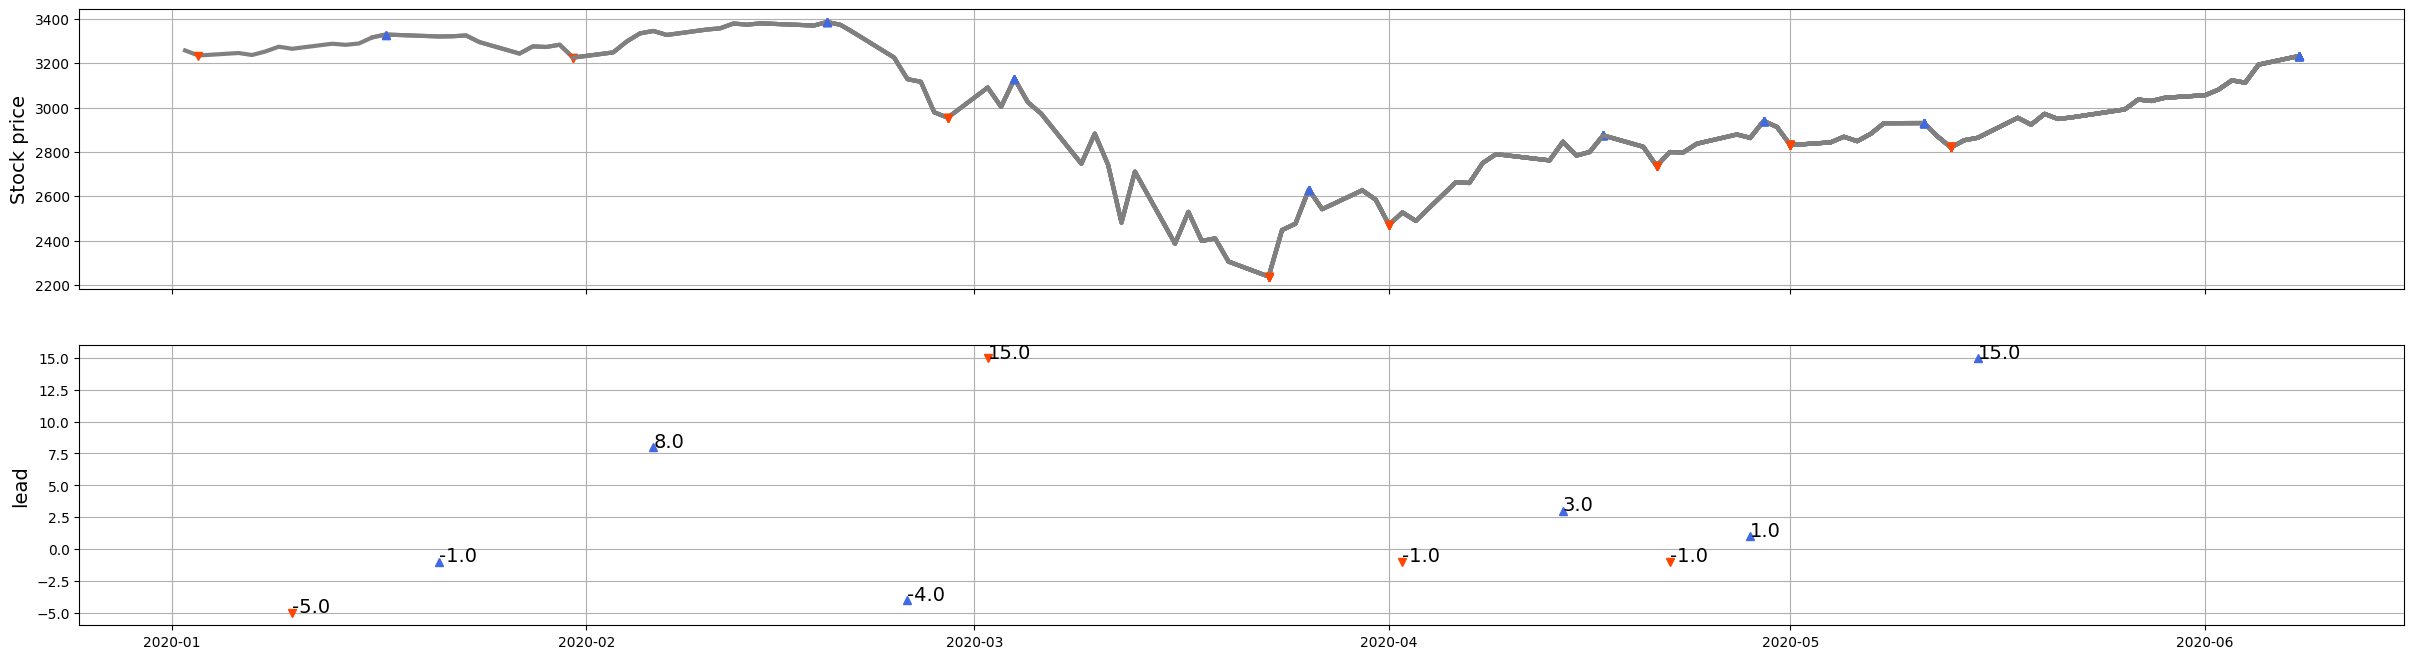

In [61]:
draw_plot_result_table_1(test_data, all_data, result_table, pv_range)

In [62]:
def draw_sarima_result(test_data, model_prediction, best_fit_harm):
    for i in test_data:
        print(i)
        fig, axes = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
        pdq = best_fit_harm[i]
        prediction = model_prediction[i][pdq].loc[len(test_data[i]['Close'])+1: len(test_data[i]['Close'])*2]
        prediction.index = test_data[i]['Close'].index[0:len(prediction.index)]
        axes[0].plot(test_data[i]['Close'].index, test_data[i]['Close'], label='test')
        axes[1].plot(prediction['Close'].index, prediction['Close'], label='predictions')
        for j, label in enumerate(prediction['pv']):
            if test_data[i]['pv'][j] == 'peak':
                axes[0].plot(test_data[i]['Close'].index[j], test_data[i]['Close'][j], '^',
                            c='royalblue')
            elif test_data[i]['pv'][j] == 'valley':
                axes[0].plot(test_data[i]['Close'].index[j], test_data[i]['Close'][j], 'v',
                            c='orangered')
            if prediction['pv'][j] == 'peak':
                axes[1].plot(prediction['Close'].index[j], prediction['Close'][j], '^',
                            c='royalblue')
            elif prediction['pv'][j] == 'valley':
                axes[1].plot(prediction['Close'].index[j], prediction['Close'][j], 'v',
                            c='orangered')
        axes[0].set_title(i, fontsize=40)
        plt.legend()
        plt.show()

data_0


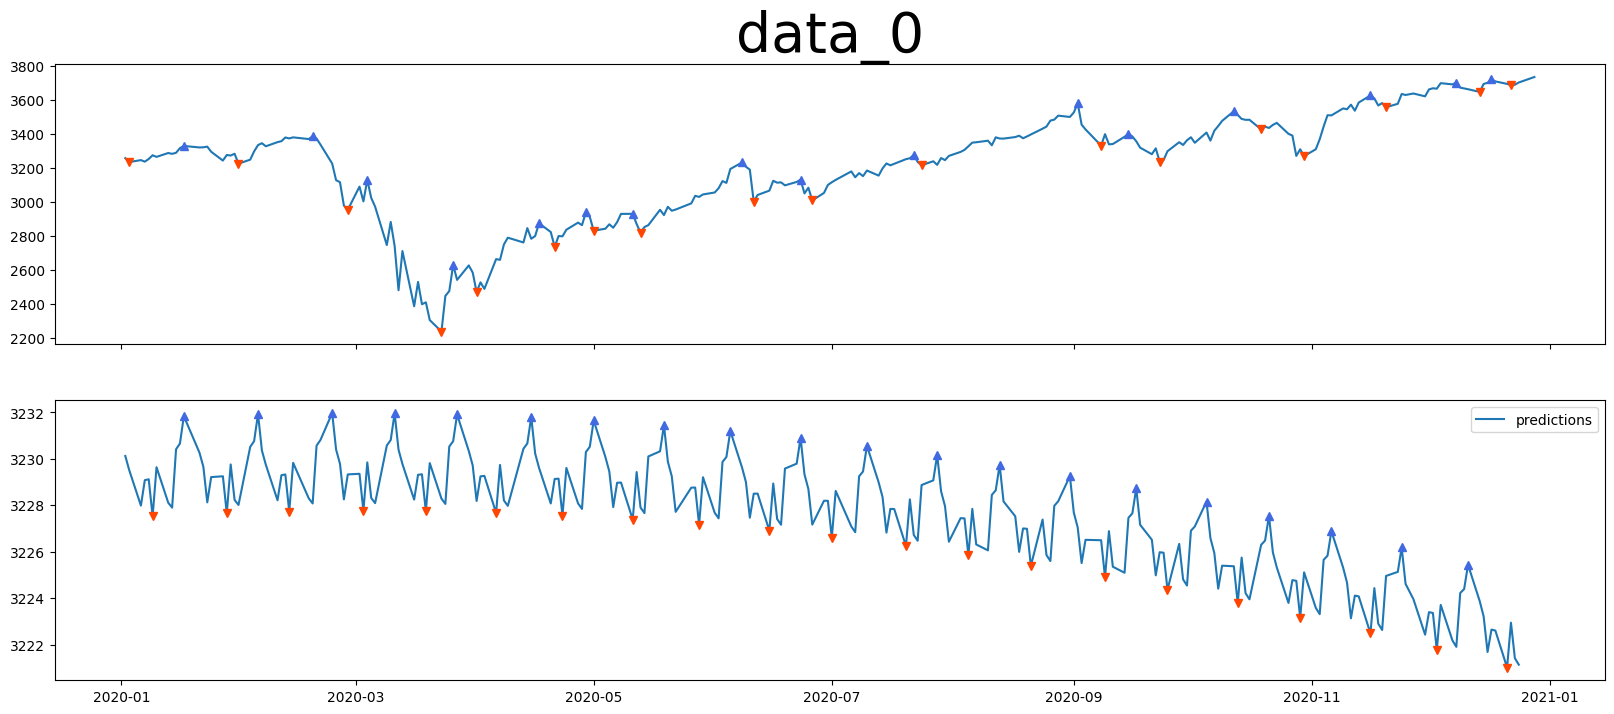

data_1


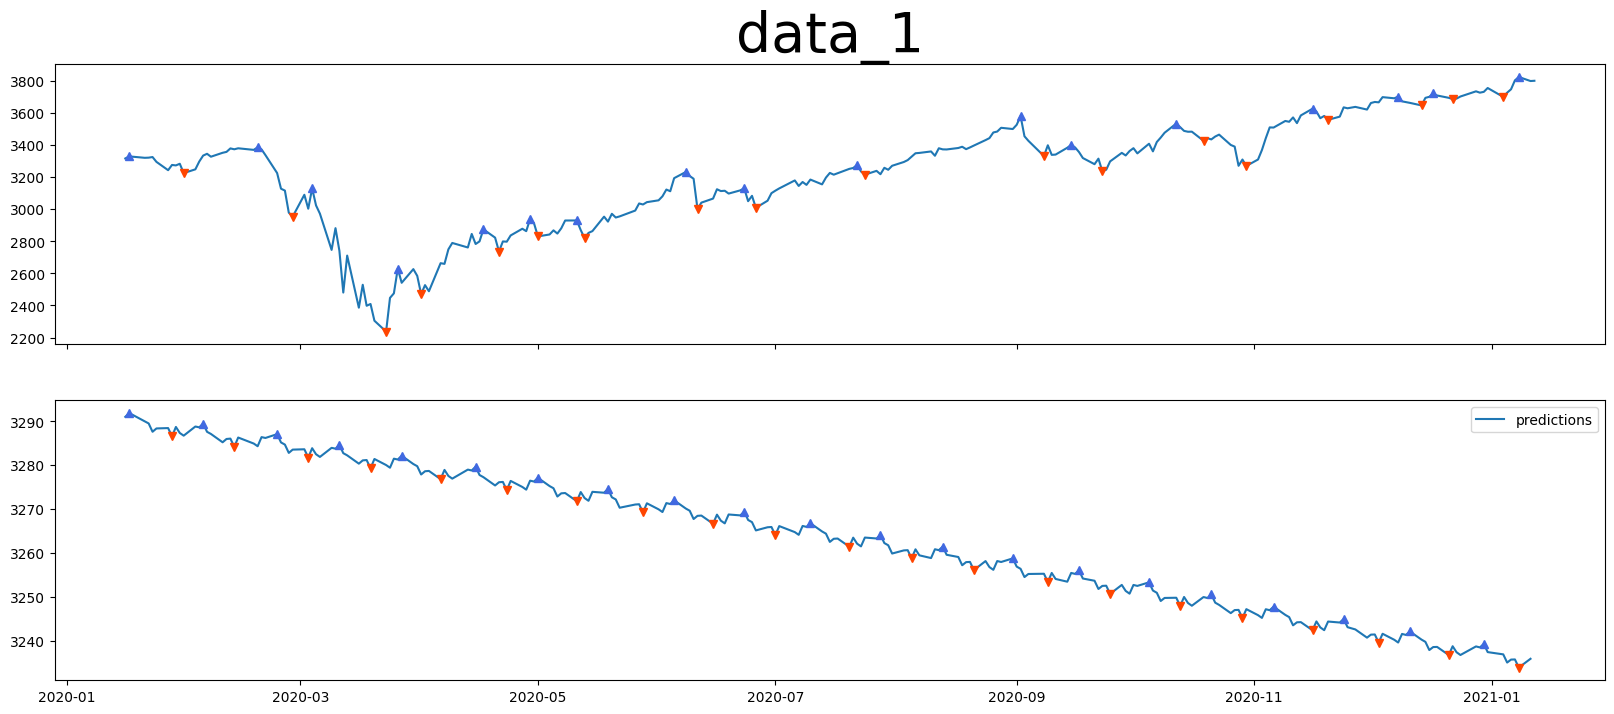

data_2


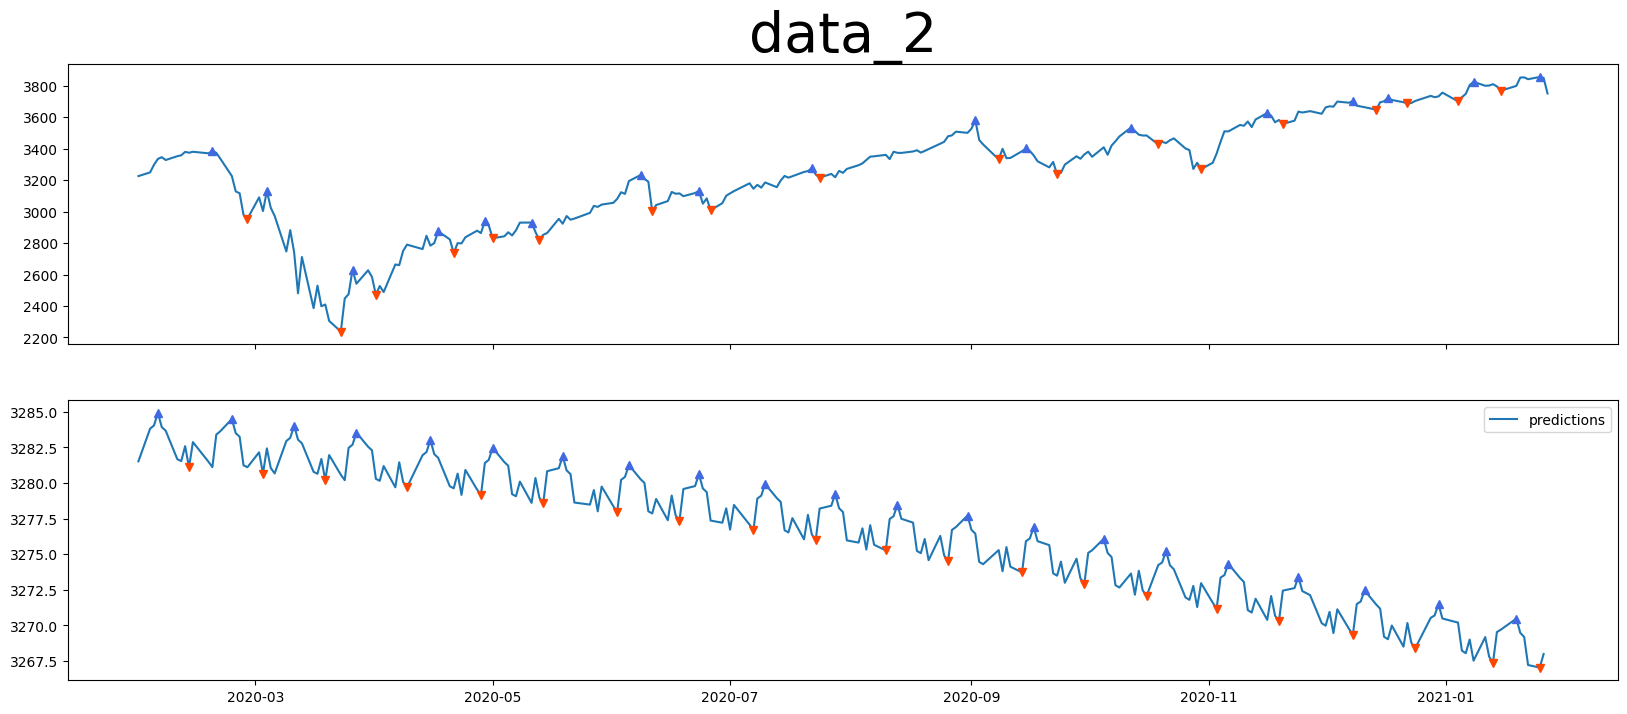

data_3


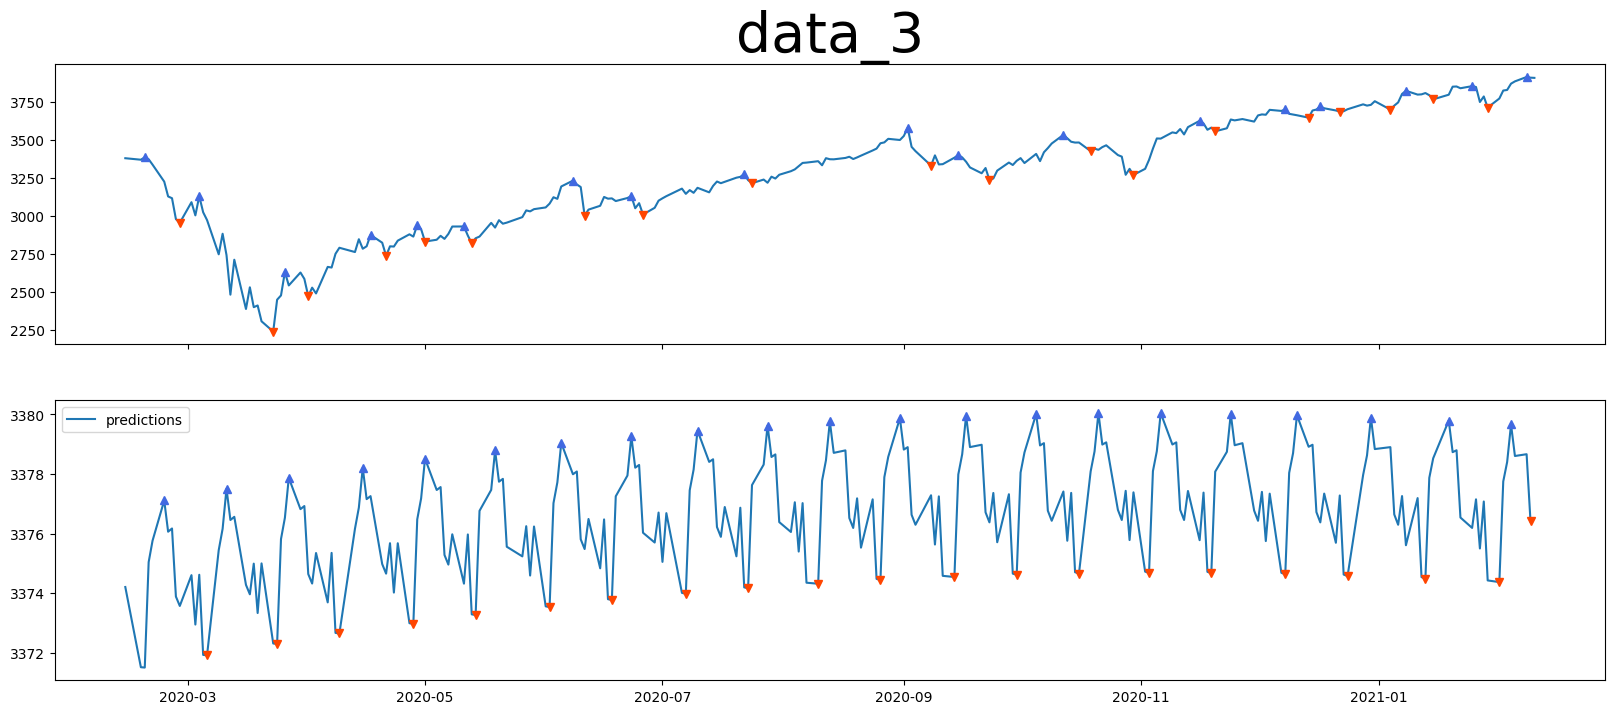

data_4


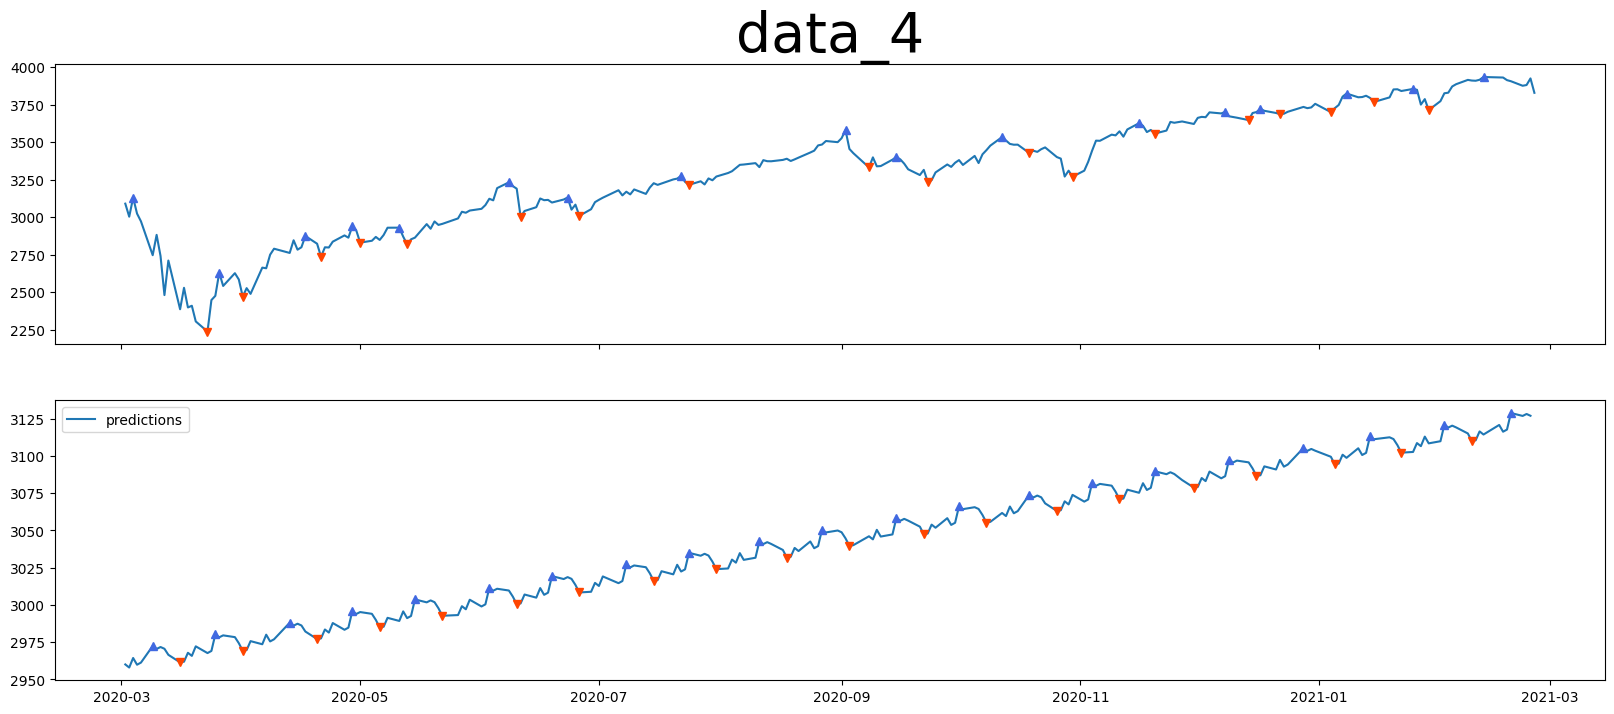

data_5


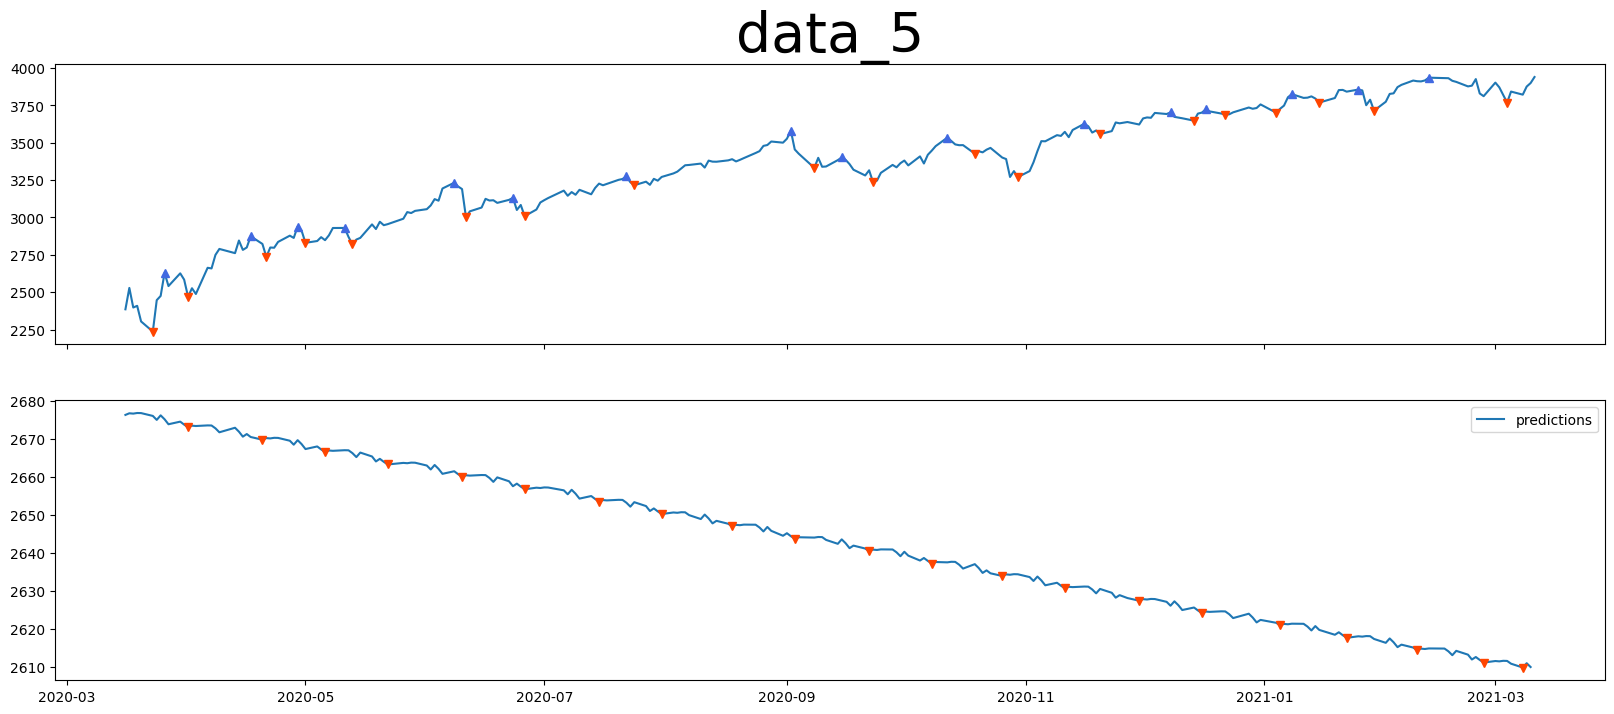

data_6


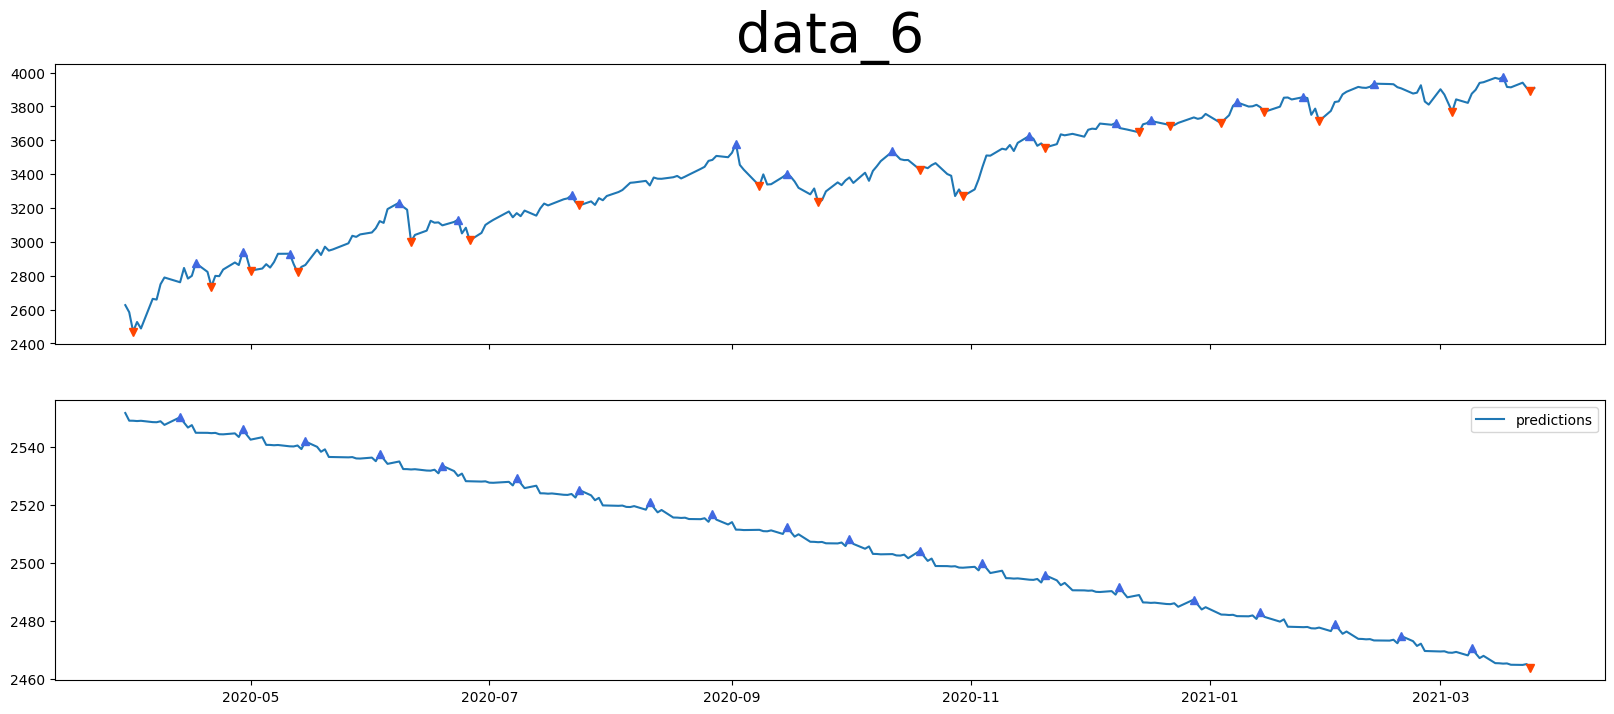

data_7


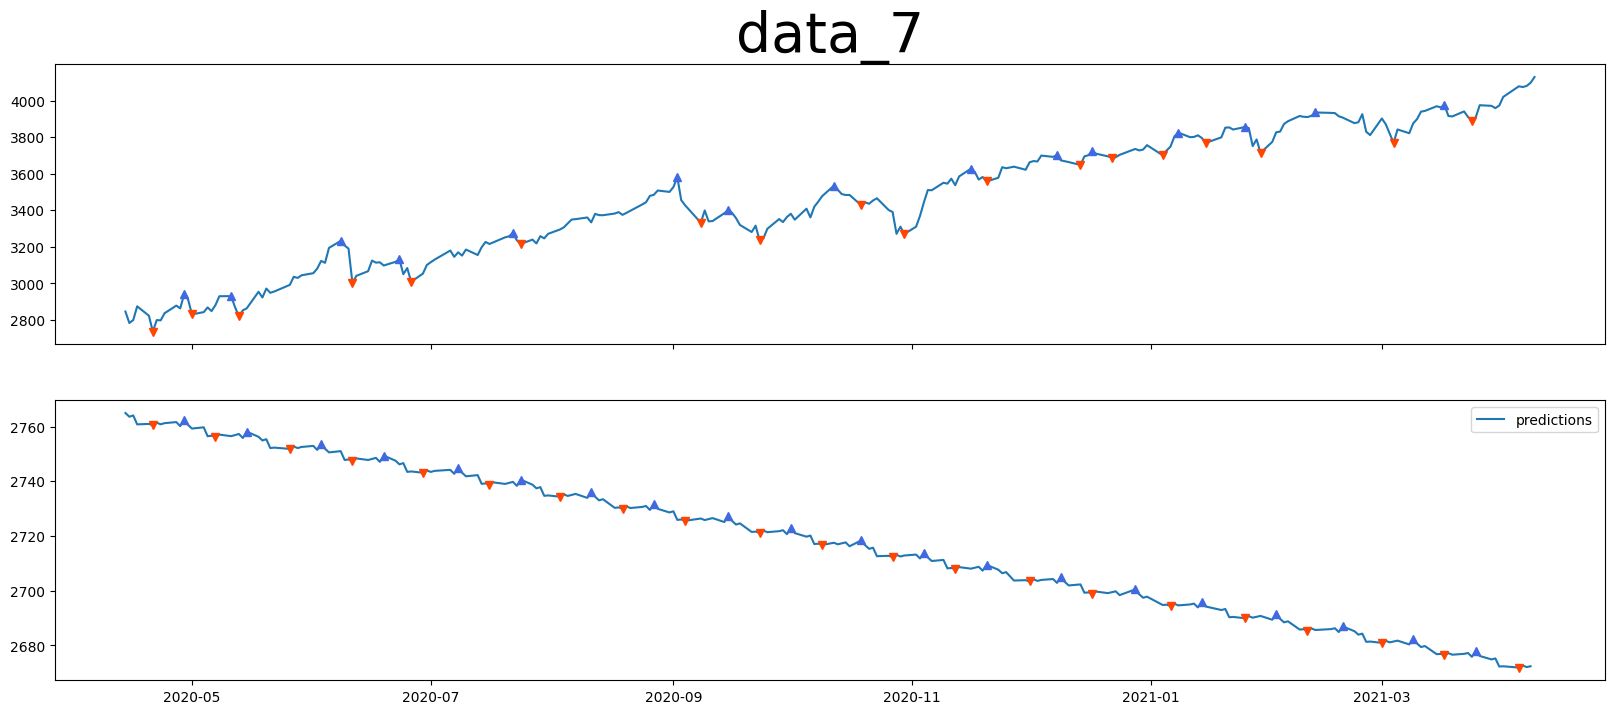

data_8


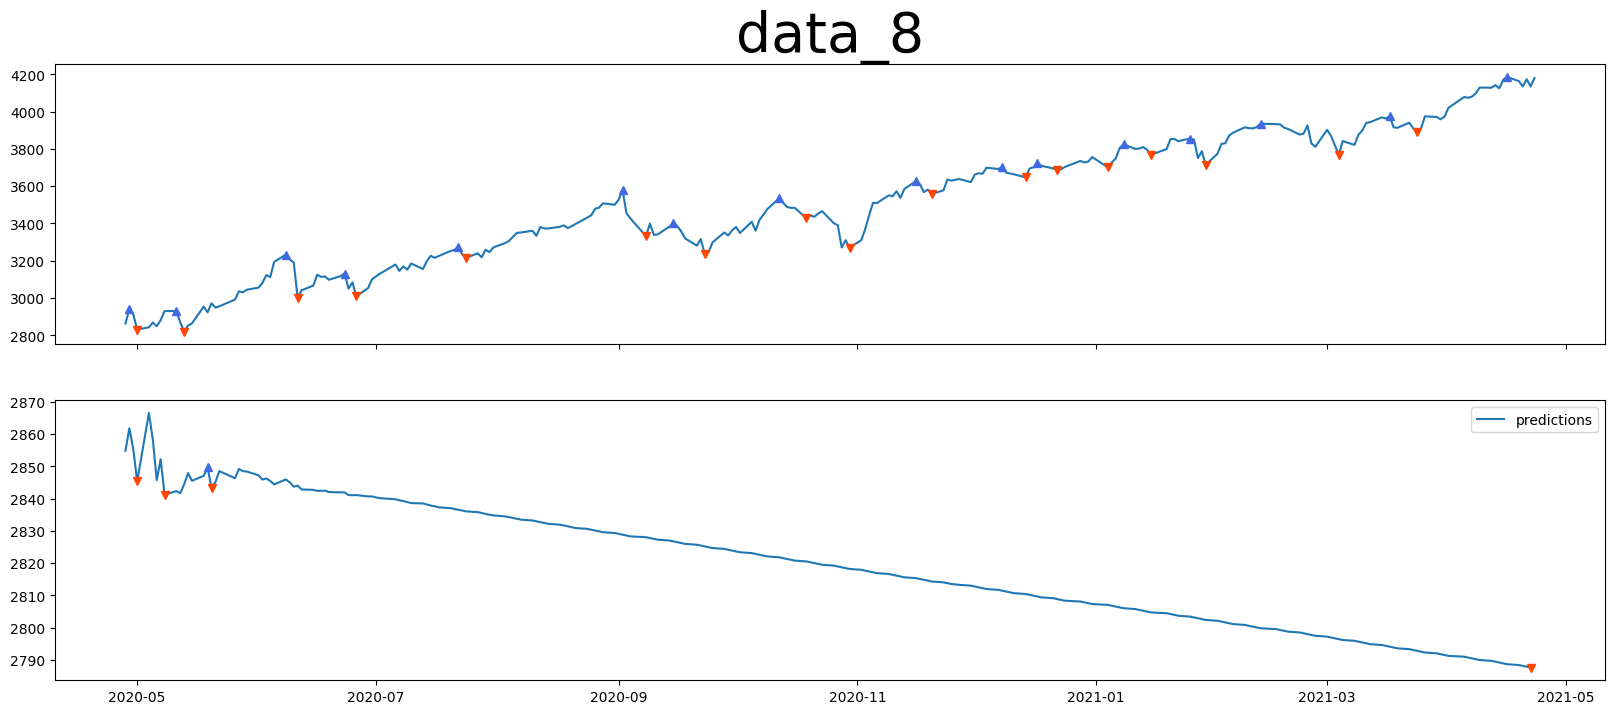

data_9


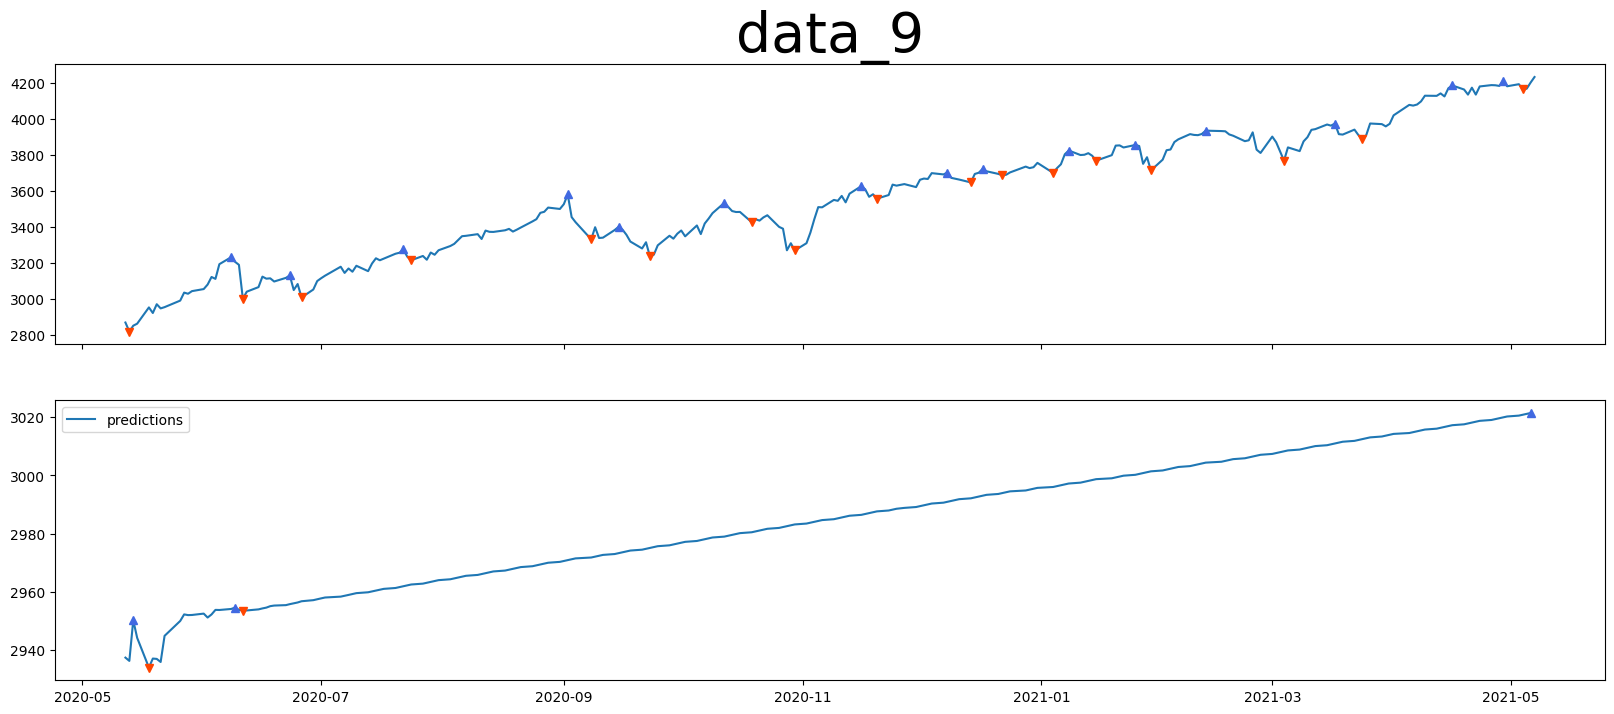

In [63]:
draw_sarima_result(test_data, model_prediction, best_fit_harm)

data_0


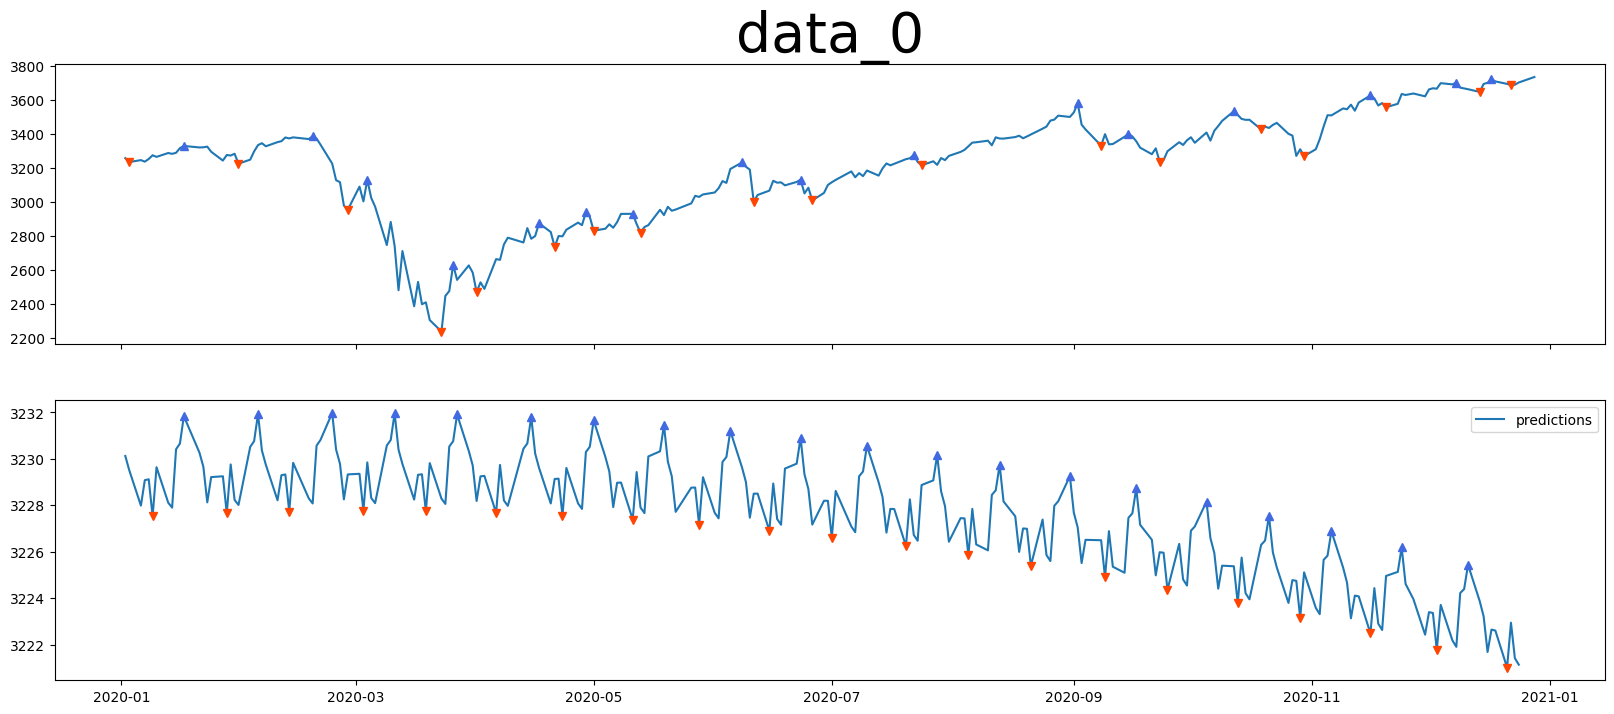

data_1


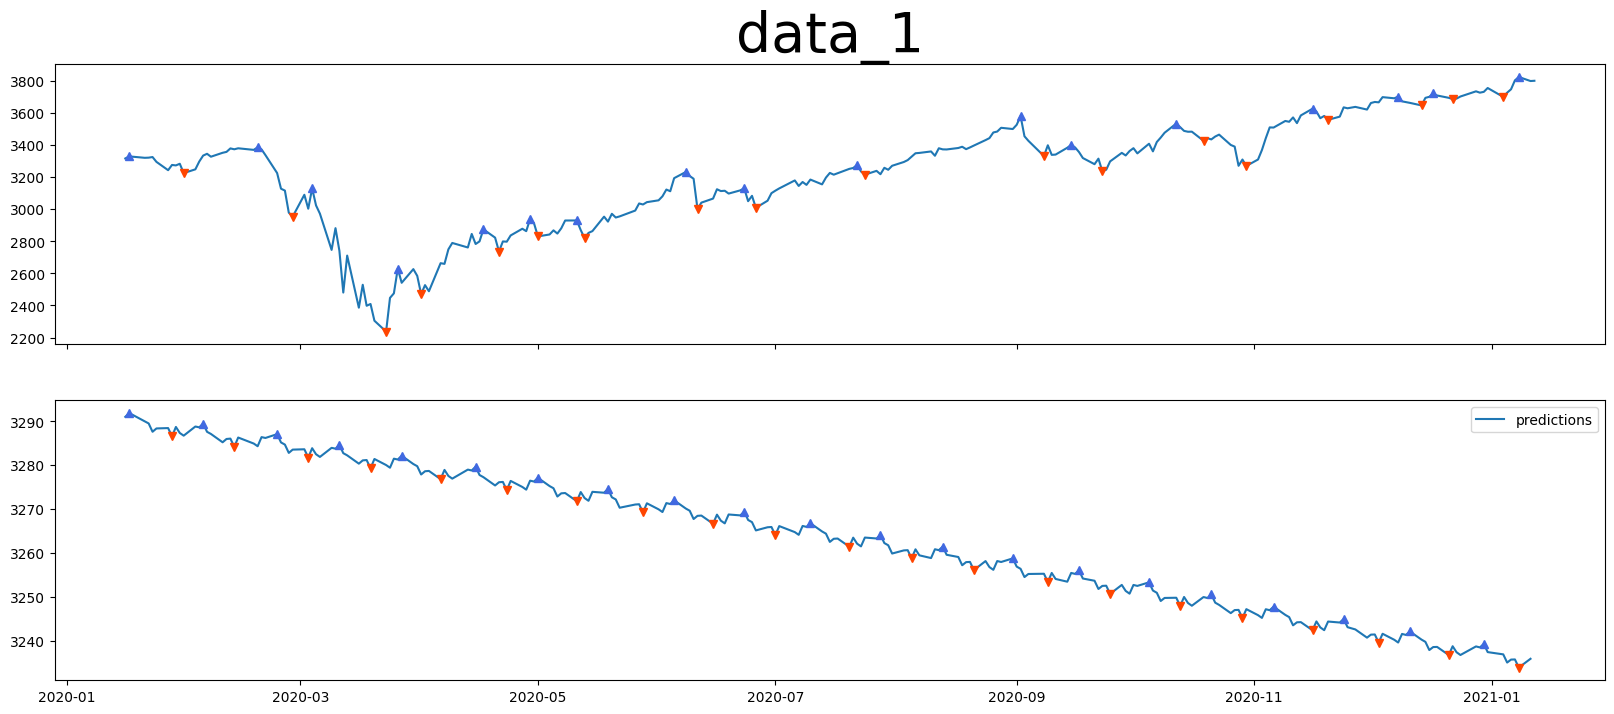

data_2


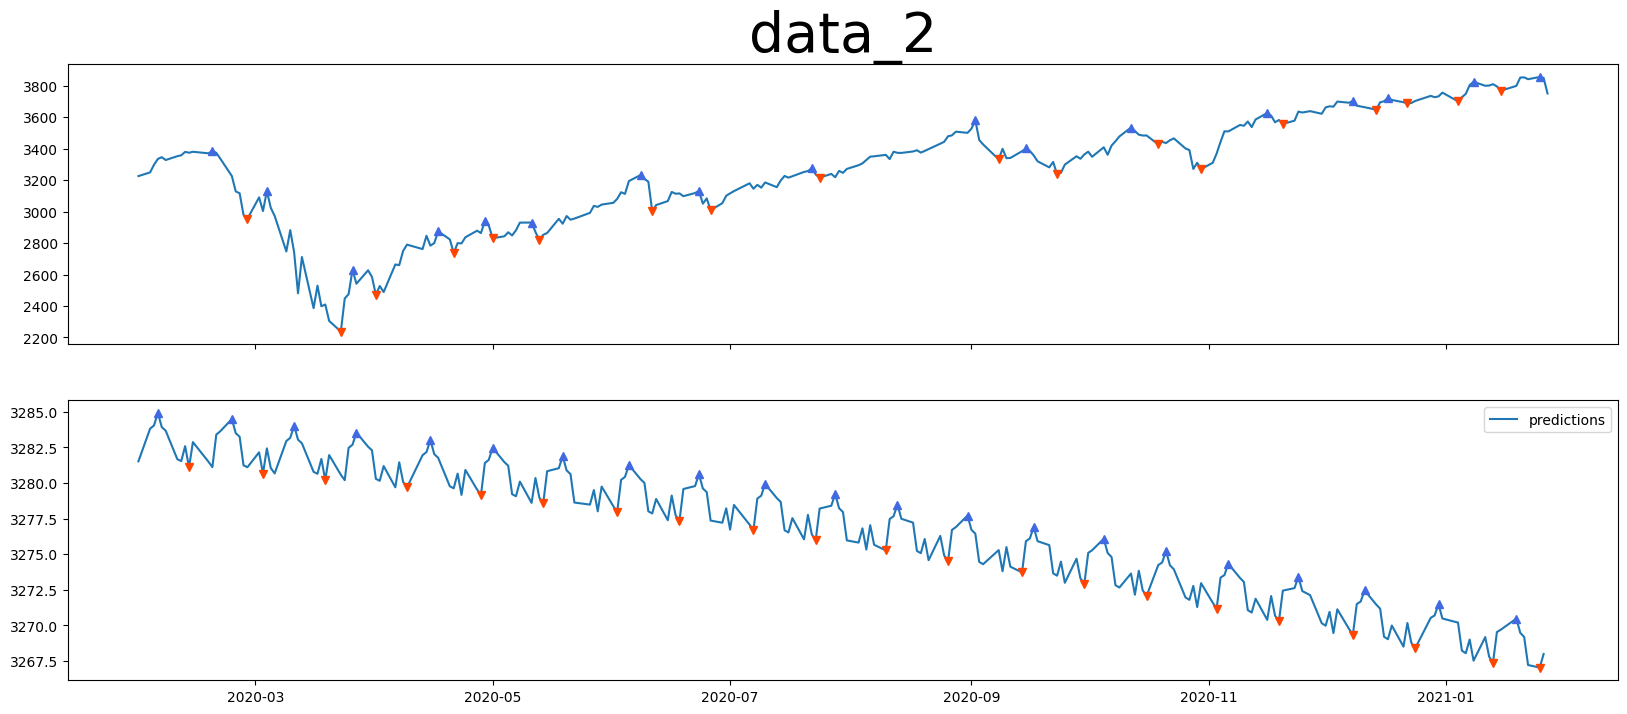

data_3


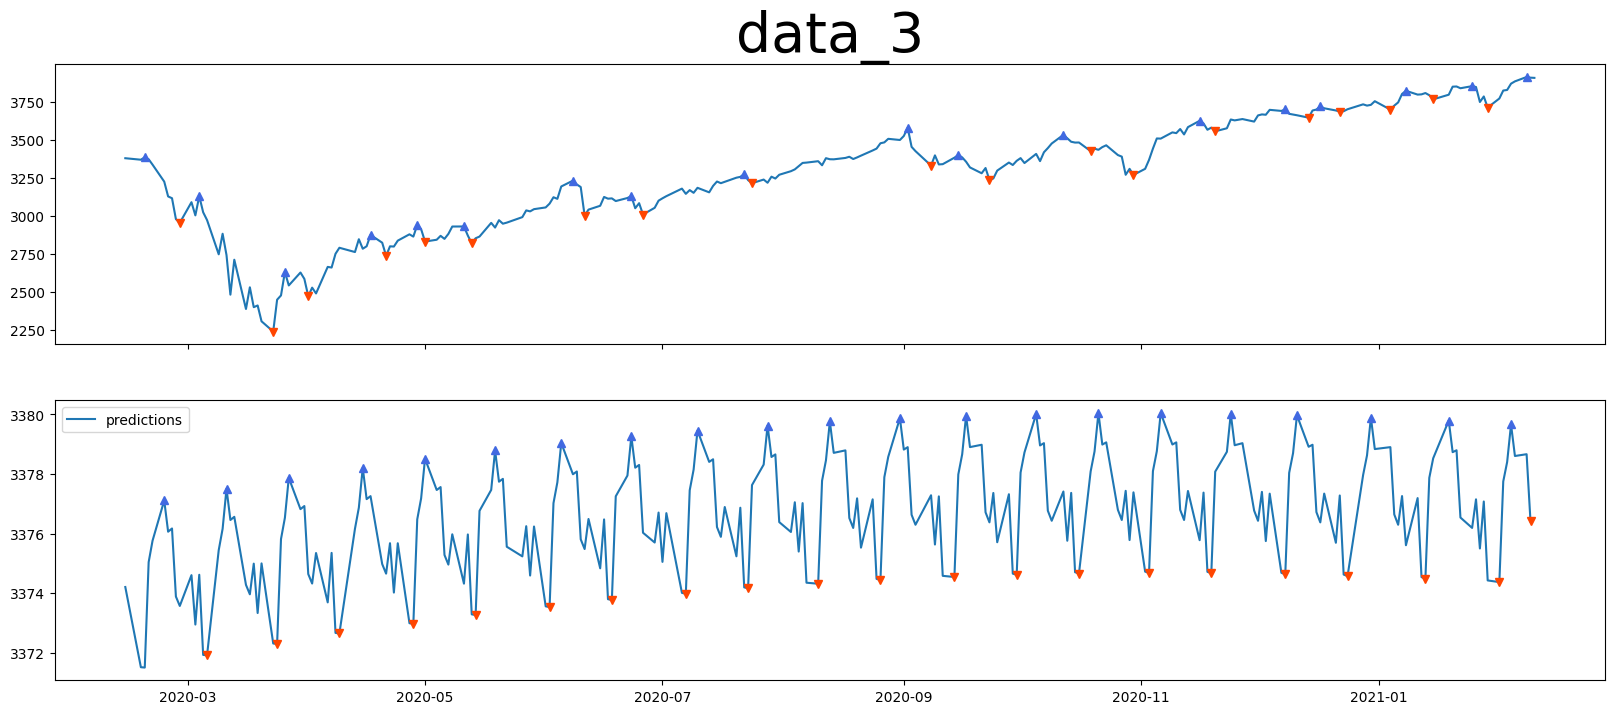

data_4


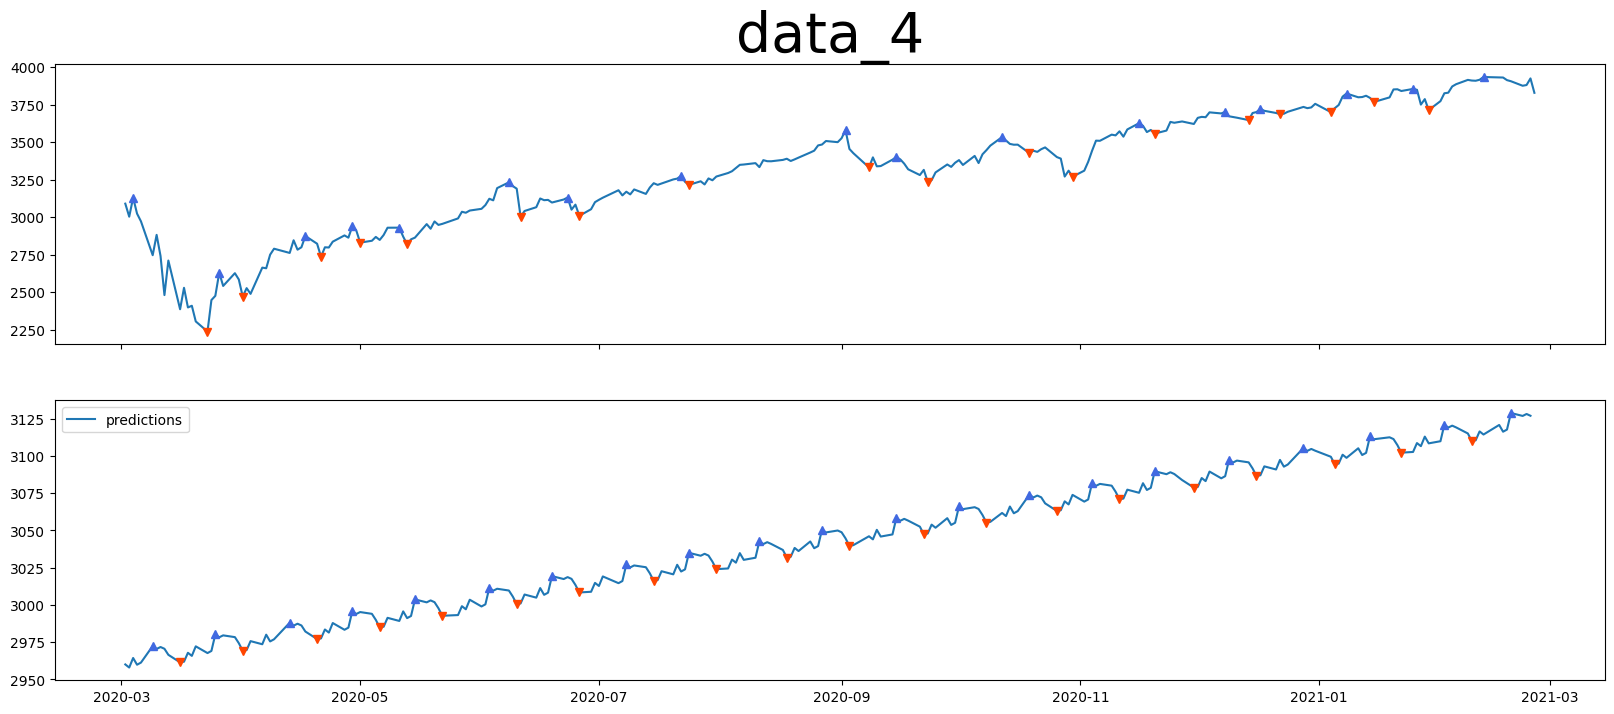

data_5


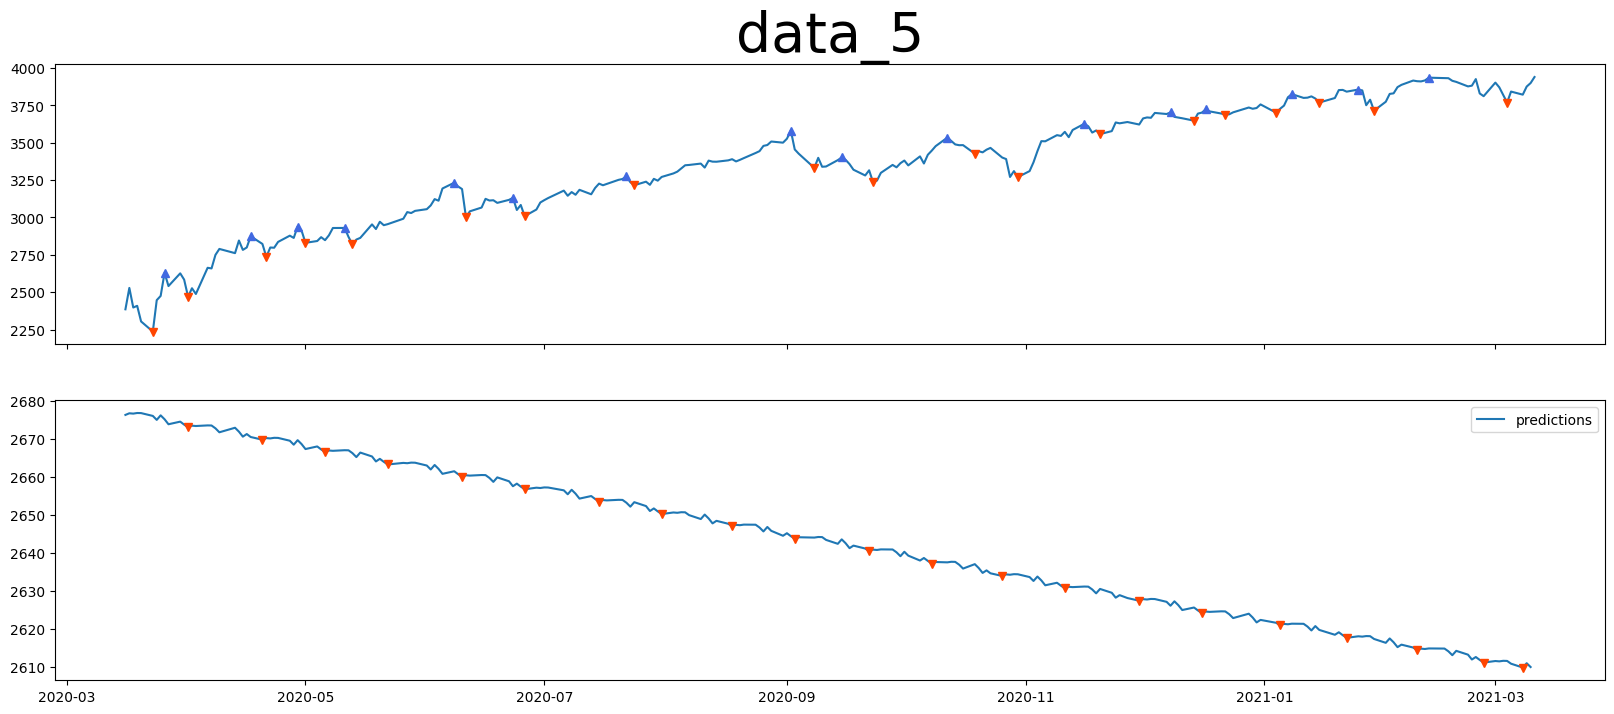

data_6


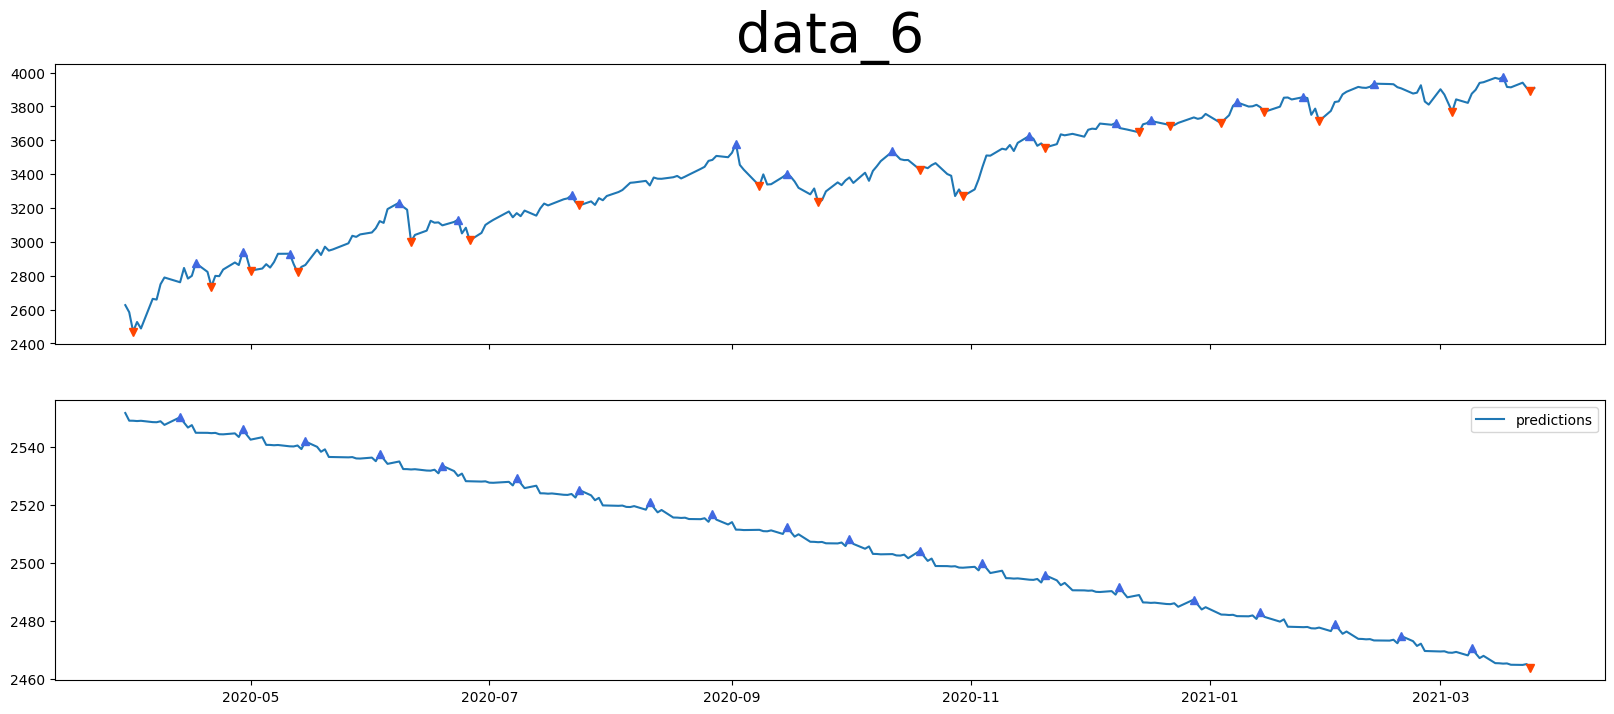

data_7


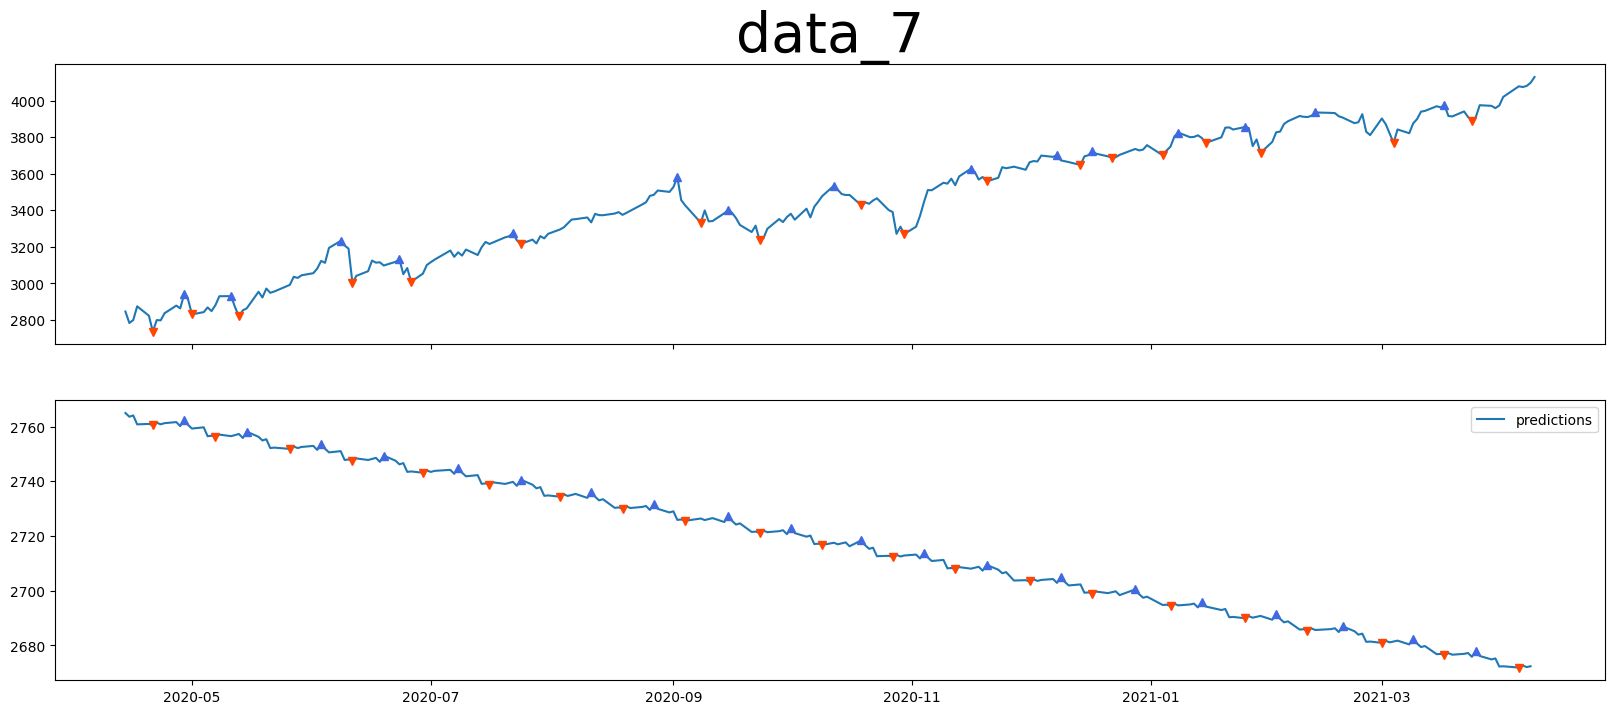

data_8


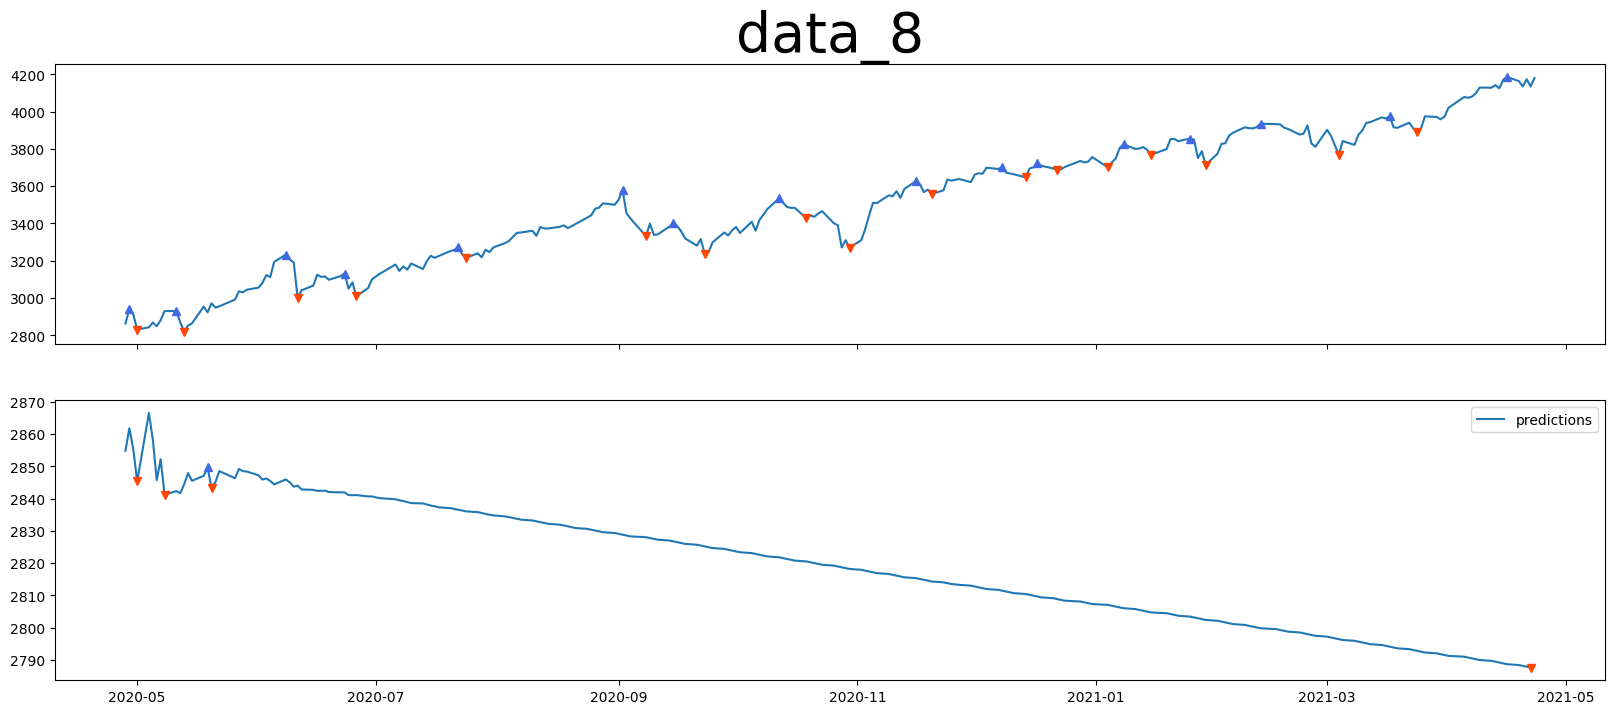

data_9


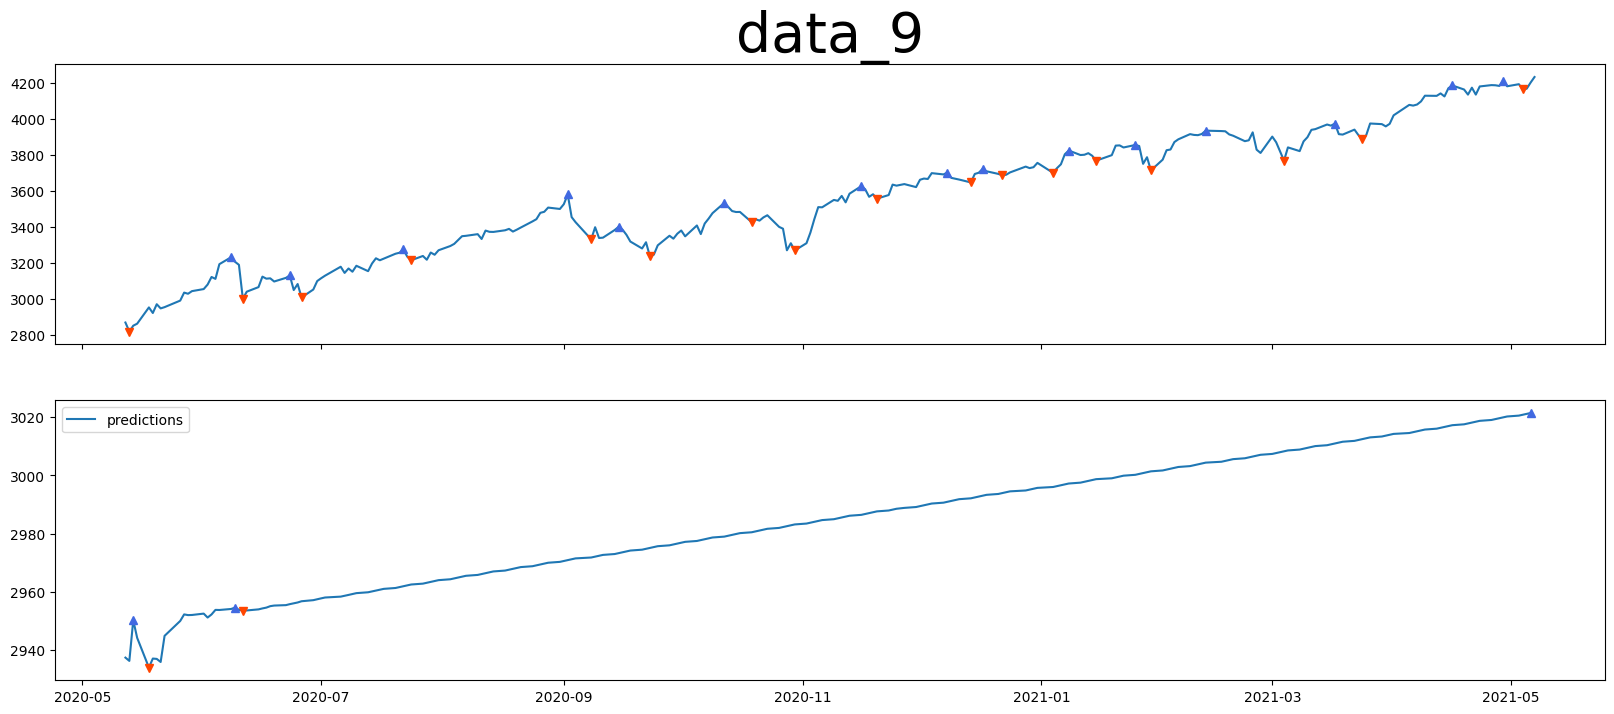

In [64]:
draw_sarima_result(test_data, model_prediction, best_fit_harm)

In [65]:
# def draw_plot_result_table_2(test_data, all_data, result_table, pv_range):
#     date_list = sorted(
#         list(result_table['s_date']) + list(result_table['t_date']) + list(result_table['ans_date']))
#     all_index = all_data.loc[date_list[0]:date_list[-1]].index
#     fig, axes = plt.subplots(2, 1, figsize=(30, 8), sharex=True)
#     for d in test_data :
#         test_data[d].index = test_data[d]['index']
#         test_data[d] = test_data[d].drop(test_data[d][test_data[d].index > date_list[-1]].index)
#         axes[0].plot(test_data[d].index, test_data[d]['Close'], 'gray', label='data', linewidth=3)
#     for d in test_data :
#         axes[0].plot(test_data[d].index, test_data[d]['peaks'],
#                     '^', c='royalblue', label='peaks')
#         axes[0].plot(test_data[d].index, test_data[d]['valleys'], 'v',
#                     c='orangered', label='valleys')
#     plot_model = pd.DataFrame(index=all_index, columns=[
#                                 's_date', 't_date', 'ans_date', 'lead', 'pv'])
#     plot_model['s_date'].loc[result_table['s_date']] = True
#     plot_model['t_date'].loc[result_table['t_date']] = True
#     plot_model['lead'].loc[result_table['t_date']] = list(result_table['lead'])
#     plot_model['pv'].loc[result_table['t_date']] = list(result_table['pv'])
#     plot_model['ans_date'].loc[result_table['ans_date']] = True
#     for i, label in enumerate(plot_model['lead']):
#         if plot_model['pv'][i] == 'peak':
#             # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#             #             c='red')
#             axes[1].plot(plot_model.index[i], plot_model['lead'][i], '^',
#                             c='royalblue')
#             text = str(label)
#             axes[1].annotate(text, (plot_model.index[i],
#                                 plot_model['lead'][i]), fontsize=14)
#         elif plot_model['pv'][i] == 'valley':
#             # axes[0].plot(plot_data.index[i], plot_data['Close'].iloc[i], '|',
#             #             c='red')
#             axes[1].plot(plot_model.index[i], plot_model['lead'][i], 'v',
#                             c='orangered')
#             text = str(label)
#             axes[1].annotate(text, (plot_model.index[i],
#                                 plot_model['lead'][i]), fontsize=14)

#     axes[0].set_ylabel("Stock price", fontsize=14)
#     axes[0].grid(True)
#     axes[1].grid(True)
#     axes[1].set_ylabel("lead", fontsize=14)
#     plt.show()


In [66]:
# draw_plot_result_table_2(test_data, all_data, result_table, pv_range)

In [67]:
# draw_sarima_result(test_data, model_prediction, best_fit_harm)
